# Imports and environment

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
import os
from datetime import datetime
from sklearn.model_selection import train_test_split, ParameterGrid
from tqdm import tqdm
import warnings
from IPython.display import display as disp

In [2]:
import sys
sys.path.append('.')
from src import *

In [3]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 200)

sns.set()
warnings.filterwarnings('ignore')

# Загрузка данных

In [4]:
path_root = '.'
path_court = os.path.join(path_root, 'court_cases_sample', 'success')

In [5]:
df_acc = pd.read_csv(os.path.join(path_root, 'df_accounts_sample.csv'))
df_bank = pd.read_csv(os.path.join(path_root, 'df_bankruptcies_sample.csv'))

# Обзор и предобработка

## Таблица accounts

### Обзор

In [6]:
df_acc.head()

,Unnamed: 0,inn,year,long_term_liabilities_fiscal_year,short_term_liabilities_fiscal_year,balance_assets_fiscal_year,okei
0,0,2465002653,2012,0.0,113756,122240,384
1,1,3505003270,2012,21461.0,20211,81132,384
2,2,3517003250,2012,0.0,0,48063,384
3,3,5501078737,2012,0.0,288763,419522,384
4,4,6140019517,2012,0.0,0,11089,384


In [7]:
df_acc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1035 entries, 0 to 1034
Data columns (total 7 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Unnamed: 0                          1035 non-null   int64  
 1   inn                                 1035 non-null   int64  
 2   year                                1035 non-null   int64  
 3   long_term_liabilities_fiscal_year   960 non-null    float64
 4   short_term_liabilities_fiscal_year  1035 non-null   int64  
 5   balance_assets_fiscal_year          1035 non-null   int64  
 6   okei                                1035 non-null   int64  
dtypes: float64(1), int64(6)
memory usage: 56.7 KB


In [8]:
df_acc = df_acc.drop(columns='Unnamed: 0')

В столбце long_term_liabilities_fiscal_year имеются пропуски.

In [9]:
df_acc[df_acc['long_term_liabilities_fiscal_year'].isna()].head()

,inn,year,long_term_liabilities_fiscal_year,short_term_liabilities_fiscal_year,balance_assets_fiscal_year,okei
894,1001003743,2019,NaN,4330,3930,384
898,1508000122,2020,NaN,9232,44018,384
899,1514013426,2019,NaN,96561,34354,384
900,1514013426,2020,NaN,124886,42322,384
902,1822000100,2019,NaN,6436,756,384


In [10]:
df_acc[df_acc['long_term_liabilities_fiscal_year'].isna()].shape[0]

75

### Обработка столбцов, приведение типов

Для удобства переименуем столбцы.

In [11]:
df_acc = column_renaming(
    df_acc,
    {
        'long_term_liabilities_fiscal_year': 'long',
        'short_term_liabilities_fiscal_year': 'short',
        'balance_assets_fiscal_year': 'balance',
    }
)

Выполним приведение типов.

Категориальные переменные пока будем приводить к типу int (для удобства манипулирования таблицами), а к типу category приведём их позже - на этапе формирования выборок для обучения.

In [12]:
df_acc[['long', 'short', 'balance']] = df_acc[['long', 'short', 'balance']].astype('float')
df_acc['inn'] = df_acc['inn'].astype('int')

In [13]:
df_acc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1035 entries, 0 to 1034
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   inn      1035 non-null   int64  
 1   year     1035 non-null   int64  
 2   long     960 non-null    float64
 3   short    1035 non-null   float64
 4   balance  1035 non-null   float64
 5   okei     1035 non-null   int64  
dtypes: float64(3), int64(3)
memory usage: 48.6 KB


Применим и удалим столбец okei.

In [14]:
df_acc['okei'].value_counts()

384    1031
383       4
Name: okei, dtype: int64

In [15]:
df_acc['okei'] = (
    df_acc['okei']
    .where(df_acc['okei'] != 383, 1)
    .where(df_acc['okei'] != 384, 1000)
    .where(df_acc['okei'] != 385, 1000000)
)
df_acc[['long', 'short', 'balance']] = df_acc[['long', 'short', 'balance']].apply(
    lambda x: x * df_acc['okei']
)
df_acc = df_acc.drop(columns='okei')

### Пропуски

Проанализируем пропуски.

In [16]:
disp(df_acc[df_acc['long'].isna()]['inn'].unique().shape[0] / df_acc['inn'].unique().shape[0])
disp(df_acc[df_acc['long'].isna()].head(10))

0.26506024096385544

,inn,year,long,short,balance
894,1001003743,2019,NaN,4330000.0,3930000.0
898,1508000122,2020,NaN,9232000.0,44018000.0
899,1514013426,2019,NaN,96561000.0,34354000.0
900,1514013426,2020,NaN,124886000.0,42322000.0
902,1822000100,2019,NaN,6436000.0,756000.0
903,1822000100,2020,NaN,6436000.0,756000.0
904,1822000100,2020,NaN,6082000.0,747000.0
907,2107004611,2019,NaN,8802000.0,8967000.0
908,2107004611,2020,NaN,8802000.0,8967000.0
909,2111008200,2020,NaN,12704000.0,252000.0


По 26,5% компаниям имеются случаи отсутствия данных по долгосрочным обязательствам.

In [17]:
df_acc[df_acc['long'].isna()]['year'].unique()

array([2019, 2020])

Данные отсутствуют только за 2019 или за 2020 год.

Посмотрим подробнее.

In [18]:
nan_inn = df_acc[df_acc['long'].isna()]['inn'].unique()

disp(
    df_acc[df_acc['inn'].isin(nan_inn)].sort_values(by=['inn', 'year']).head(20)
)
disp(nan_inn.shape[0])

nan_inn_zeropresence = df_acc[
    (df_acc['inn'].isin(nan_inn))
    & (df_acc['long'] == 0)
]['inn'].unique()

disp(nan_inn_zeropresence.shape[0])
disp(
    df_acc[
        (df_acc['inn'].isin(nan_inn))
        & (df_acc['inn'].isin(nan_inn_zeropresence) != True)
    ]
)

,inn,year,long,short,balance
772,1001003743,2012,0.0,1080000.0,4399000.0
187,1001003743,2013,0.0,1080000.0,4399000.0
357,1001003743,2014,0.0,296000.0,6295000.0
548,1001003743,2015,0.0,260000.0,6051000.0
623,1001003743,2016,0.0,861000.0,4735000.0
300,1001003743,2017,0.0,8379000.0,9481000.0
862,1001003743,2018,0.0,3881000.0,4003000.0
894,1001003743,2019,NaN,4330000.0,3930000.0
87,1508000122,2012,0.0,0.0,49822000.0
111,1508000122,2013,0.0,19481000.0,28904000.0


44

43

,inn,year,long,short,balance
215,7455005950,2013,38411000.0,4198000.0,45890000.0
436,7455005950,2014,43478000.0,6209000.0,55777000.0
517,7455005950,2015,57827000.0,36051000.0,89383000.0
773,7455005950,2012,38411000.0,4198000.0,45890000.0
1002,7455005950,2019,NaN,0.0,4000.0
1003,7455005950,2020,NaN,0.0,1000.0


Компаний, по которым есть пропуски, - всего 44.

В 43 из 44 характер пропусков - такой, как показан в первой таблице: данные пропущены только за последний год, а по всем предыдущим годам обязательства - нулевые.

Единственный отличающийся случай отражён во второй таблице: обязательства и баланс сначала были ненулевые, а в последние два года - стали либо строго нулевые (краткосрочные обязательства), либо близки к нулю (баланс).

Будет справедливо заполнить все пропуски нулями: в обоих случаях это наиболее логичный вариант. В первых 43 случаях нет оснований считать, что тенденция нарушится именно в последний год; в последнем, отдельном случае нулевые значения long будут соответствовать логике двух других столбцов.

Заполним пропуски.

In [19]:
df_acc['long'] = df_acc['long'].fillna(0.0)
df_acc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1035 entries, 0 to 1034
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   inn      1035 non-null   int64  
 1   year     1035 non-null   int64  
 2   long     1035 non-null   float64
 3   short    1035 non-null   float64
 4   balance  1035 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 40.6 KB


### Выбросы

Проверим, есть ли выбросы.

In [20]:
df_acc.describe()

,inn,year,long,short,balance
count,1.035000e+03,1035.000000,1.035000e+03,1.035000e+03,1.035000e+03
mean,5.024548e+09,2015.515942,1.049745e+08,8.854885e+07,2.256735e+08
std,2.198715e+09,2.420593,8.387213e+08,3.022655e+08,9.777282e+08
min,1.001004e+09,2012.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.212001e+09,2013.000000,0.000000e+00,1.376000e+06,4.054000e+06
50%,5.404263e+09,2015.000000,0.000000e+00,7.850000e+06,1.693200e+07
75%,6.907010e+09,2017.000000,9.040000e+05,5.245000e+07,9.024400e+07
max,9.102060e+09,2020.000000,9.844742e+09,4.842980e+09,1.032725e+10


Выбросов нет.

### Дубликаты

Проверим таблицу на наличие дубликатов.

In [21]:
df_acc[df_acc.duplicated()]

,inn,year,long,short,balance
920,2465002653,2019,0.000000e+00,34938000.0,60193000.0
922,2508012923,2019,1.776100e+07,261371000.0,668960000.0
934,3212001450,2020,3.163600e+07,50415000.0,52494000.0
991,6725005494,2019,1.224496e+09,210799000.0,11000.0
1008,7703065332,2019,1.040130e+08,2354000.0,113846000.0


Удалим дубликаты.

In [22]:
df_acc = df_acc.drop_duplicates().reset_index(drop=True)

Проверим также таблицу на наличие дубликатов относительно столбцов inn и year. Такие дубликаты тоже необходимо удалить, так как нам требуется однозначное соответствие между ИНН и значениями за определённый год.

In [23]:
df_acc[df_acc.duplicated(keep=False, subset=['inn', 'year'])]

,inn,year,long,short,balance
903,1822000100,2020,0.0,6436000.0,756000.0
904,1822000100,2020,0.0,6082000.0,747000.0
1004,7703065332,2020,104013000.0,1482000.0,112154000.0
1005,7703065332,2020,104013000.0,1481000.0,112154000.0
1008,7717783534,2019,0.0,4252000.0,61298000.0
1009,7717783534,2019,0.0,4252000.0,55298000.0


Некоторые значения различаются (поэтому такие строки и не были выявлены на предыдущем шаге), но различия не критичны. Поэтому просто удалим эти дубликаты.

In [24]:
df_acc = df_acc.drop_duplicates(subset=['inn', 'year']).reset_index(drop=True)

##  Таблица bankruptcies

### Обзор

In [25]:
df_bank.head()

,Unnamed: 0,bankrupt_id,bancrupt_year,inn
0,0,79546,2015,5620006322
1,1,76594,2015,2111008200
2,2,94301,2016,5414100369
3,3,93799,2019,2347009476
4,4,199671,2018,7224008489


In [26]:
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Unnamed: 0     106 non-null    int64
 1   bankrupt_id    106 non-null    int64
 2   bancrupt_year  106 non-null    int64
 3   inn            106 non-null    int64
dtypes: int64(4)
memory usage: 3.4 KB


In [27]:
df_bank = df_bank.drop(columns='Unnamed: 0')

### Обработка столбцов, приведение типов

Идентификатор банкротства нам не потребуется, так как интересует только год, а идентификация компании осуществляется по ИНН.

Удалим столбец bancrupt_id.

In [28]:
df_bank = df_bank.drop(columns='bankrupt_id')

Для удобства переименуем столбец.

In [29]:
df_bank = column_renaming(
    df_bank,
    {
        'bancrupt_year': 'yearb',
    }
)

Выполним приведение типов.

In [30]:
df_bank['yearb'] = df_bank['yearb'].fillna(0).astype('int')
df_bank['inn'] = df_bank['inn'].astype('int')

In [31]:
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   yearb   106 non-null    int64
 1   inn     106 non-null    int64
dtypes: int64(2)
memory usage: 1.8 KB


### Выбросы

Проверим, есть ли выбросы.

In [32]:
df_bank.describe()

,yearb,inn
count,106.000000,1.060000e+02
mean,2016.792453,5.088171e+09
std,2.984777,2.166806e+09
min,2011.000000,1.020010e+09
25%,2014.250000,3.268141e+09
50%,2017.000000,5.410220e+09
75%,2019.000000,6.858008e+09
max,2021.000000,8.909000e+09


Выбросов нет.

### Дубликаты

Проверим таблицу на наличие дубликатов.

In [33]:
df_bank['inn'][df_bank['inn'].duplicated()]

Series([], Name: inn, dtype: int64)

Дубликатов нет.

## Файлы court cases

### Формирование списка файлов

Сформируем список файлов.

In [34]:
filenames = listdir_without_ipynb_checkpoints(path_court)
filenames[:5]

['.DS_Store',
 '1001003743.pkl',
 '1001227084.pkl',
 '1020010136_b.pkl',
 '1203000142_b.pkl']

In [35]:
len(filenames)

194

In [36]:
i = 0
while i < len(filenames):
    if '.pkl' not in filenames[i]:
        del filenames[i]
    else:
        i += 1

len(filenames)

193

### Изучение структуры файла

Откроем первый в списке файл и посмотрим его состав.

In [37]:
with open(os.path.join(path_court, filenames[0]), 'rb') as f:
    file = pickle.load(f)

In [38]:
for key in file.keys():
    print(key)

inn
cases_list
error
n_requests


In [39]:
print(file['inn'])

1001003743


In [40]:
print(file['error'])

None


In [41]:
print(file['n_requests'])

1


In [42]:
len(file['cases_list'])

4

In [43]:
for key in file['cases_list'][0].keys():
    print(key)

caseNo
resultType
caseDate
caseType
sum
currency
isActive
currentInstance
instanceDate
documents
case_sides


Проверим, одинакова ли структура у всех файлов.

In [44]:
lengths = np.zeros((len(filenames), 3), dtype='int')
root_values = np.zeros((len(filenames), 2), dtype='object')
for i, filename in enumerate(filenames):
    lengths_item = np.zeros(3, dtype='int')
    with open(os.path.join(path_court, filename), 'rb') as f:
        file = pickle.load(f)
    lengths_item[0] = len(file.keys())
    lengths_item[1] = len(file['cases_list'])
    if len(file['cases_list']) > 1:
        cases_list_lengths = np.array([])
        for case in file['cases_list']:
            cases_list_lengths = np.append(cases_list_lengths, len(case))
        if np.unique(cases_list_lengths).shape[0] == 1:
            lengths_item[2] = len(file['cases_list'][0])
        else:
            lengths_item[2] = -1
    root_values[0] = file['error']
    root_values[1] = file['n_requests']
    lengths[i] = lengths_item

In [45]:
np.unique(lengths[:, 0])

array([4])

In [46]:
np.unique(lengths[:, 2])

array([ 0, 11])

In [47]:
np.unique(lengths[:, 1])

array([  0,   1,   2,   3,   4,   5,   6,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  24,  25,  26,  27,
        28,  29,  31,  32,  33,  35,  37,  38,  39,  40,  41,  42,  43,
        45,  46,  47,  48,  50,  52,  56,  59,  64,  66,  69,  74,  79,
        84,  85,  86,  88,  89,  95,  98, 115, 125, 134, 136, 140, 142,
       148, 149, 155, 164, 173, 254, 262, 358, 408, 588, 619, 624])

In [48]:
root_values[:, 0]

array([None, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=object)

In [49]:
root_values[:, 1]

array([None, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=object)

Структура одинакова, за исключением длины списка cases_list.

Рассмотрим один из элементов этого списка.

In [50]:
disp(file['cases_list'][0])

{'caseNo': 'А83-21847/2020',
 'resultType': 'Проиграно',
 'caseDate': '2020-12-22T00:00:00',
 'caseType': {'code': '6',
  'name': 'экономические споры по гражданским правоотношениям'},
 'sum': 43200.0,
 'currency': 643,
 'isActive': False,
 'currentInstance': 'АС Республики Крым',
 'instanceDate': '2021-05-14T18:26:48',
 'documents': [{'document_name': 'Решение суда первой инстанции',
   'document_date': '2021-05-14T00:00:00',
   'document': 'http://kad.arbitr.ru/kad/pdfdocument/b6877332-626a-4c87-95f3-6f0d1930de5a/A83-21847-2020_20210514_Reshenija_i_postanovlenija.pdf',
   'judge_name': 'Радвановская Ю. А.',
   'court_name': 'АС Республики Крым'},
  {'document_name': 'Об отложении судебного разбирательства',
   'document_date': '2021-04-09T00:00:00',
   'document': 'http://kad.arbitr.ru/kad/pdfdocument/492591af-bcca-4c31-9dac-98e8585e17a4/A83-21847-2020_20210409_Opredelenie.pdf',
   'judge_name': 'Радвановская Ю. А.',
   'court_name': 'АС Республики Крым'},
  {'document_name': 'О расс

### Формирование таблицы

Сформируем из файлов единую таблицу.

В таблицу не будем включать список документов (documents), так как уже на данном этапе ясно, что эта информация не представляет ценности для решения задачи.

Сначала формируем список столбцов.

In [51]:
with open(os.path.join(path_court, filenames[0]), 'rb') as f:
    file = pickle.load(f)
df_court_dict_cols = []
for key in file['cases_list'][0].keys():
    df_court_dict_cols.append(key)
del df_court_dict_cols[-2]
df_court_dict_cols.insert(0, 'inn')
df_court_dict_cols

['inn',
 'caseNo',
 'resultType',
 'caseDate',
 'caseType',
 'sum',
 'currency',
 'isActive',
 'currentInstance',
 'instanceDate',
 'case_sides']

Заполним таблицу.

Если в файле нет информации ни об одном суде (компания не судилась), заполним поля максимально нейтральными данными.

Для компактности поле case_type заполним только кодом, без расшифровки. Расшифровку сохраним отдельно.

В поле case_sides укажем только сторону, которую занимает рассматриваемая компания (соотнесём по ИНН).

In [52]:
df_court = pd.DataFrame(
    np.empty((0, len(df_court_dict_cols)), dtype='object'),
    columns=df_court_dict_cols
)

dummies_amount = 0
for filename in filenames:
    with open(os.path.join(path_court, filename), 'rb') as f:
        file = pickle.load(f)
    df_court_file = pd.DataFrame(
        np.empty((np.clip(len(file['cases_list']), 1, None), len(df_court_dict_cols)), dtype='object'),
        columns=df_court_dict_cols
    )
    if len(file['cases_list']) > 0:
        for i in np.arange(len(file['cases_list'])):
            df_court_file.loc[i, 'inn'] = file['inn']
            df_court_file.loc[i, 'caseNo'] = file['cases_list'][i]['caseNo']
            df_court_file.loc[i, 'resultType'] = file['cases_list'][i]['resultType']
            df_court_file.loc[i, 'caseDate'] = file['cases_list'][i]['caseDate']
            df_court_file.loc[i, 'caseType'] = file['cases_list'][i]['caseType']['code']
            df_court_file.loc[i, 'caseType_name'] = file['cases_list'][i]['caseType']['name']
            df_court_file.loc[i, 'sum'] = file['cases_list'][i]['sum']
            df_court_file.loc[i, 'currency'] = file['cases_list'][i]['currency']
            df_court_file.loc[i, 'isActive'] = file['cases_list'][i]['isActive']
            df_court_file.loc[i, 'currentInstance'] = file['cases_list'][i]['currentInstance']
            df_court_file.loc[i, 'instanceDate'] = file['cases_list'][i]['instanceDate']
            side_type = 0
            for side in file['cases_list'][i]['case_sides']:
                try:
                    if int(side['INN']) == int(file['inn']):
                        side_type = side['type']
                        break
                except:
                    None
            df_court_file.loc[i, 'case_sides'] = side_type
    else:
        dummies_amount += 1
        i = 0
        df_court_file.loc[i, 'inn'] = file['inn']
        df_court_file.loc[i, 'caseNo'] = str(np.random.randint(1e10))
        df_court_file.loc[i, 'resultType'] = 'Не удалось определить'
        df_court_file.loc[i, 'caseDate'] = '2021-08-09T10:00:00'
        df_court_file.loc[i, 'caseType'] = '90'
        df_court_file.loc[i, 'caseType_name'] = 'не определено'
        df_court_file.loc[i, 'sum'] = 0.0
        df_court_file.loc[i, 'currency'] = 643
        df_court_file.loc[i, 'isActive'] = False
        df_court_file.loc[i, 'currentInstance'] = 'none'
        df_court_file.loc[i, 'instanceDate'] = '2021-08-09T10:00:00'
        df_court_file.loc[i, 'case_sides'] = 2
    df_court = pd.concat((df_court, df_court_file))

Посмотрим, сколько компаний из выборки никогда не судилось.

In [53]:
dummies_amount

26

Всего таких - 26. Информация о них (о судах) заменена заглушками.

In [54]:
df_caseType_names = (
    df_court[['caseType', 'caseType_name']]
    .drop_duplicates()
    .set_index('caseType')['caseType_name']
    .to_dict()
)
df_court = df_court.drop(columns='caseType_name')
df_caseType_names

{'6': 'экономические споры по гражданским правоотношениям',
 '5': 'экономические споры по административным правоотношениям',
 '90': 'не определено',
 '1': 'о несостоятельности (банкротстве) организаций и граждан',
 '73': 'об административных правонарушениях',
 '3': 'об оспаривании решений трет. судов и о выдаче исп. листов на принудительное исполнение решений трет. судов',
 '4': 'об установлении фактов, имеющих юридическое значение'}

Удалим дубликаты.

In [55]:
df_court = df_court.drop_duplicates().reset_index(drop=True)

In [56]:
df_court.head()

,inn,caseNo,resultType,caseDate,caseType,sum,currency,isActive,currentInstance,instanceDate,case_sides
0,1001003743,А26-5468/2020,Частично выиграно,2020-06-26T00:00:00,6,1459183.0,643,False,АС Республики Карелия,2021-07-07T00:00:00,0
1,1001003743,А26-2373/2014,Не удалось определить,2014-03-31T00:00:00,6,79200.0,643,False,АС Республики Карелия,2014-07-10T00:00:00,0
2,1001003743,А26-10653/2010,Выиграно,2010-12-20T00:00:00,5,0.0,643,False,АС Республики Карелия,2012-02-02T00:00:00,0
3,1001003743,А26-9908/2010,Не удалось определить,2010-11-22T00:00:00,5,0.0,643,False,ФАС Северо-Западного округа,2011-08-10T00:00:00,0
4,1001227084,5703390920,Не удалось определить,2021-08-09T10:00:00,90,0.0,643,False,none,2021-08-09T10:00:00,2


In [57]:
df_court.shape

(7970, 11)

### Обработка столбцов

Проверим некоторые столбцы, различаются ли в них значения.

In [58]:
df_court['caseType'].value_counts()

6     6238
5      933
1      557
90     183
3       39
4       13
73       7
Name: caseType, dtype: int64

In [59]:
df_court['currency'].value_counts()

643    7970
Name: currency, dtype: int64

In [60]:
df_court['isActive'].value_counts()

False    7744
True      226
Name: isActive, dtype: int64

Удалим столбец currency, так как он содержит одинаковое для всех строк значение.

In [61]:
df_court = df_court.drop(columns='currency')

In [62]:
df_court.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7970 entries, 0 to 7969
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   inn              7970 non-null   object
 1   caseNo           7970 non-null   object
 2   resultType       7970 non-null   object
 3   caseDate         7970 non-null   object
 4   caseType         7970 non-null   object
 5   sum              7970 non-null   object
 6   isActive         7970 non-null   object
 7   currentInstance  7970 non-null   object
 8   instanceDate     7970 non-null   object
 9   case_sides       7970 non-null   object
dtypes: object(10)
memory usage: 622.8+ KB


### Приведение типов

Выполним приведение типов, а также кодировку значений некоторых столбцов.

In [63]:
df_court[['caseType', 'case_sides']] = df_court[['caseType', 'case_sides']].astype('int')
df_court['inn'] = df_court['inn'].astype('int')
df_court['sum'] = df_court['sum'].astype('float')

In [64]:
df_court['isActive'] = df_court['isActive'].apply(lambda x: 1 if x == True else 0).astype('int')
df_court['isActive'].value_counts()

0    7744
1     226
Name: isActive, dtype: int64

In [65]:
df_court.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7970 entries, 0 to 7969
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   inn              7970 non-null   int64  
 1   caseNo           7970 non-null   object 
 2   resultType       7970 non-null   object 
 3   caseDate         7970 non-null   object 
 4   caseType         7970 non-null   int64  
 5   sum              7970 non-null   float64
 6   isActive         7970 non-null   int64  
 7   currentInstance  7970 non-null   object 
 8   instanceDate     7970 non-null   object 
 9   case_sides       7970 non-null   int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 622.8+ KB


In [66]:
df_court['caseDate'] = pd.to_datetime(
    df_court['caseDate'], format='%Y-%m-%d'
).dt.normalize()

Столбец instanceDate тоже следует привести к типу datetime, однако в нём была выявлена аномалия - некорректное значение года, что вызвало исключение.

Необходимо обработать все аномалии и затем выполнить приведение.

### Аномалии

Проверим весь столбец на наличие подобных аномалий.

In [67]:
anomalies_index = df_court['instanceDate'][
    (df_court['instanceDate'].str.slice(start=0, stop=4).astype('int') < 1990)
    | (df_court['instanceDate'].str.slice(start=0, stop=4).astype('int') > datetime.now().year)
].index
df_court.loc[anomalies_index]

,inn,caseNo,resultType,caseDate,caseType,sum,isActive,currentInstance,instanceDate,case_sides
3205,3501000166,А76-10413/2009,Не удалось определить,2009-05-25,6,1344085.25,0,АС Челябинской области,7457-10-04T00:00:00,0


Аномалия - единственная. Заменим её на значение из столбца caseDate, поскольку они близки по смыслу (дата открытия дела и дата последнего рассмотрения).

In [68]:
df_court.loc[anomalies_index, 'instanceDate'] = df_court.loc[anomalies_index, 'caseDate']
df_court['instanceDate'] = pd.to_datetime(
    df_court['instanceDate'], format='%Y-%m-%d'
).dt.normalize()

In [69]:
df_court.head()

,inn,caseNo,resultType,caseDate,caseType,sum,isActive,currentInstance,instanceDate,case_sides
0,1001003743,А26-5468/2020,Частично выиграно,2020-06-26,6,1459183.0,0,АС Республики Карелия,2021-07-07,0
1,1001003743,А26-2373/2014,Не удалось определить,2014-03-31,6,79200.0,0,АС Республики Карелия,2014-07-10,0
2,1001003743,А26-10653/2010,Выиграно,2010-12-20,5,0.0,0,АС Республики Карелия,2012-02-02,0
3,1001003743,А26-9908/2010,Не удалось определить,2010-11-22,5,0.0,0,ФАС Северо-Западного округа,2011-08-10,0
4,1001227084,5703390920,Не удалось определить,2021-08-09,90,0.0,0,none,2021-08-09,2


### Дубликаты

Исследуем дубликаты.

In [70]:
df_court[df_court['caseNo'].duplicated(keep=False)].shape[0]

174

In [71]:
df_court[df_court['caseNo'].duplicated(keep=False)].head(10)

,inn,caseNo,resultType,caseDate,caseType,sum,isActive,currentInstance,instanceDate,case_sides
24,1020010136,А26-5094/2018,Проиграно,2018-05-30,6,681100.24,0,АС Республики Карелия,2018-08-10,1
25,1020010136,А26-5094/2018,Иск полностью удовлетворен,2018-05-30,6,681100.24,0,АС Республики Карелия,2018-08-10,1
42,1020010136,А26-11429/2017,Выиграно,2017-11-08,1,32651260.11,0,АС Республики Карелия,2021-01-13,0
43,1020010136,А26-11429/2017,Проиграно,2017-11-08,1,32651260.11,0,АС Республики Карелия,2021-01-13,0
52,1020010136,А26-7261/2017,Проиграно,2017-07-25,6,835095.19,0,АС Республики Карелия,2017-11-01,1
53,1020010136,А26-7261/2017,Иск полностью удовлетворен,2017-07-25,6,835095.19,0,АС Республики Карелия,2017-11-01,1
331,1203000142,А65-19288/2013,Выиграно,2013-08-28,1,18305.41,0,АС Республики Татарстан,2015-05-14,0
332,1203000142,А65-19288/2013,Иск полностью удовлетворен,2013-08-28,1,18305.41,0,АС Республики Татарстан,2015-05-14,0
391,1203000142,А17-221/2010,Проиграно,2010-01-19,1,30463245.73,0,АС Волго-Вятского округа,2016-04-11,1
392,1203000142,А17-221/2010,Иск полностью удовлетворен,2010-01-19,1,30463245.73,0,АС Волго-Вятского округа,2016-04-11,1


Дубликаты различаются по столбцу resultType. Причём в одних случаях значения resultType в пределах одного caseNo противоречат друг другу, а в других - совпадают по смыслу.

Рассмотрим значения resultType.

In [72]:
df_court['resultType'].value_counts()

Не удалось определить                                          4274
Проиграно                                                      1417
Выиграно                                                        911
Частично проиграно                                              264
Не выиграно                                                     244
Частично выиграно                                               233
Не проиграно                                                    229
Иск полностью удовлетворен                                      193
В иске отказано полностью                                       121
Иск частично удовлетворен                                        40
Утверждено мировое соглашение                                    24
Иск не рассмотрен                                                14
Прекращено производство по делу                                   3
Иск полностью удовлетворен, встречный частично удовлетворен       1
Иск частично удовлетворен, встречный не удовлетв

Закодируем значения resultType следующим образом:
* 0: положительный исход;
* 1: отрицательный исход;
* 2: исход не определён.

In [73]:
resultType_encode_dict = {
    'Не удалось определить': 2,
    'Проиграно': 0,
    'Выиграно': 1, 
    'Частично проиграно': 0,
    'Не выиграно': 2,
    'Частично выиграно': 1,
    'Не проиграно': 2,
    'Иск полностью удовлетворен': 1,
    'В иске отказано полностью': 0,
    'Иск частично удовлетворен': 1,
    'Утверждено мировое соглашение': 1,
    'Иск не рассмотрен': 2,
    'Прекращено производство по делу': 2,
    'Иск полностью удовлетворен, встречный частично удовлетворен': 1,
    'Иск частично удовлетворен, встречный не удовлетворен': 1,
    'В иске отказано частично': 0,
}

Мировое соглашение можно интерпретировать и как положительный, и как отрицательный исход в зависимости от того, какую сторону представляет компания в суде, истца или ответчика. Стороны договорились в суде, но не понятно, кто кому уступил. Поскольку таких случаев в выборке немного, просто отнесём результат к неопределённому.

In [74]:
df_court['resultType'] = df_court['resultType'].apply(
    lambda x: resultType_encode_dict[x]
).astype('int')
df_court['resultType'].value_counts()

2    4764
0    1803
1    1403
Name: resultType, dtype: int64

Удалим полностью продублированные строки: будут удалены те, в которых совпадают закодированные исходы дела.

In [75]:
df_court[df_court.duplicated()].shape[0]

27

In [76]:
df_court = df_court.drop_duplicates().reset_index(drop=True)

Остались только противоречащие друг другу дубликаты.

In [77]:
df_court[df_court['caseNo'].duplicated(keep=False)].head(10)

,inn,caseNo,resultType,caseDate,caseType,sum,isActive,currentInstance,instanceDate,case_sides
24,1020010136,А26-5094/2018,0,2018-05-30,6,681100.24,0,АС Республики Карелия,2018-08-10,1
25,1020010136,А26-5094/2018,1,2018-05-30,6,681100.24,0,АС Республики Карелия,2018-08-10,1
42,1020010136,А26-11429/2017,1,2017-11-08,1,32651260.11,0,АС Республики Карелия,2021-01-13,0
43,1020010136,А26-11429/2017,0,2017-11-08,1,32651260.11,0,АС Республики Карелия,2021-01-13,0
52,1020010136,А26-7261/2017,0,2017-07-25,6,835095.19,0,АС Республики Карелия,2017-11-01,1
53,1020010136,А26-7261/2017,1,2017-07-25,6,835095.19,0,АС Республики Карелия,2017-11-01,1
390,1203000142,А17-221/2010,0,2010-01-19,1,30463245.73,0,АС Волго-Вятского округа,2016-04-11,1
391,1203000142,А17-221/2010,1,2010-01-19,1,30463245.73,0,АС Волго-Вятского округа,2016-04-11,1
603,1435087440,А58-9369/2009,1,2009-10-29,6,46622.00,0,АС Республики Саха,2009-12-09,0
604,1435087440,А58-9369/2009,2,2009-10-29,6,46622.00,0,АС Республики Саха,2009-12-09,0


In [78]:
disp(df_court[df_court['caseNo'].duplicated()].shape[0])
disp(df_court[df_court['caseNo'].duplicated()].shape[0] / df_court.shape[0])

62

0.007805615006924336

Таких дубликатов - менее 1%, что не много.

Удалим дубликаты.

In [79]:
df_court = df_court.drop_duplicates(subset='caseNo').reset_index(drop=True)

Идентификатор дела (столбец caseNo) сам по себе полезной информации не несёт. После удаления дубликатов он больше не нужен. Удалим его.

In [80]:
df_court = df_court.drop(columns='caseNo')

### Столбец currentInstance

Рассмотрим численность случаев в разрезе по регионам.

In [81]:
disp(df_court['currentInstance'].value_counts()[:10])
disp(df_court['currentInstance'].value_counts()[30:40])
disp(df_court['currentInstance'].value_counts()[-10:])

АС Челябинской области     509
АС Смоленской области      457
АС Вологодской области     435
АС города Москвы           427
АС Тверской области        300
АС Московской области      297
АС Хабаровского края       279
АС Ярославской области     268
АС Республики Татарстан    252
АС Приморского края        233
Name: currentInstance, dtype: int64

АС Курганской области               70
АС Тюменской области                70
АС Воронежской области              69
7 арбитражный апелляционный суд     67
АС Саратовской области              65
Верховный Суд РФ                    64
АС Республики Карелия               64
АС Волгоградской области            61
АС Кировской области                57
11 арбитражный апелляционный суд    56
Name: currentInstance, dtype: int64

АС Республики Адыгея              2
ФАС Восточно-Сибирского округа    2
АС Республики Крым                2
АС Тамбовской области             1
АС Новгородской области           1
АС Сахалинской области            1
АС Республики Дагестан            1
АС Магаданской области            1
Президиум Верховного Суда РФ      1
АС Астраханской области           1
Name: currentInstance, dtype: int64

С одной стороны, место рассмотрения дела не должно влиять на вероятность банкротства. Но, с другой стороны, мы наблюдаем, что количество дел от региона к региону различается на 1-2 порядка. Маловероятно, что деловая активность, например, в Тверской области (300 дел), в 150 раз интенсивнее, чем в Орловской (2 дела). Причина таких различий не очевидна, но, возможно, причинно-следственная связь действительно имеется, и модель сможет её найти.

Оставим пока столбец currentInstance без изменений.

### Столбец isActive

Посмотрим, какое количество компаний ещё не завершило судебный спор и сколько из таких компаний уже признаны банкротом (есть в списке bankruptcies).

In [82]:
disp(df_court['inn'][df_court['isActive'] == 1].unique().shape[0])
disp(
    df_court['inn'][df_court['isActive'] == 1][
        df_court['inn'][df_court['isActive'] == 1].isin(df_bank['inn'])
    ].unique().shape[0]
)

62

51

Около половины компаний судятся в настоящий момент, большинство из них признаны банкротом.

### Некорректные даты

Проверим, есть ли такие некорректные строки, где дата последнего судебного решения - более ранняя, чем дата возникновения кейса.

In [83]:
inn_instance_more = df_court[
    df_court['instanceDate'] < df_court['caseDate']
]['inn'].unique()

disp(df_court[df_court['instanceDate'] < df_court['caseDate']].shape[0])
disp(inn_instance_more.shape[0])
disp(df_court[df_court['inn'].isin(inn_instance_more)].shape[0])

4

2

379

Компаний, к которым относятся такие записи, - всего две, самих записей - четыре.

Всего записей по этим двум компаниям - 379, поэтому удалять эти компании целиком мы не будем.

Удалим только ошибочные записи.

In [84]:
df_court = df_court.drop(
    index=df_court[df_court['instanceDate'] < df_court['caseDate']].index
).reset_index(drop=True)

## Сопоставление таблиц

### Полнота информации

Проверим, соответствуют ли друг другу данные в разных таблицах.

In [85]:
df_court['inn'].unique().shape[0]

193

In [86]:
df_acc['inn'].unique().shape[0]

166

In [87]:
df_acc['inn'][df_acc['inn'].isin(df_court['inn'])].unique().shape[0]

166

In [88]:
df_court['inn'][df_court['inn'].isin(df_acc['inn'])].unique().shape[0]

166

По 27 компаням есть данные о судах, но нет данных о бухгалтерской отчётности.

In [89]:
unmatched_index = df_court[df_court['inn'].isin(df_acc['inn']) != True].index

disp(df_court.loc[unmatched_index].shape[0])
disp(df_court.loc[unmatched_index])

47

,inn,resultType,caseDate,caseType,sum,isActive,currentInstance,instanceDate,case_sides
4,1001227084,2,2021-08-09,90,0.00,0,none,2021-08-09,2
479,1214002504,2,2021-08-09,90,0.00,0,none,2021-08-09,2
602,1502000912,2,2021-08-09,90,0.00,0,none,2021-08-09,2
645,1511010480,2,2021-08-09,90,0.00,0,none,2021-08-09,2
1382,2302030982,2,2021-08-09,90,0.00,0,none,2021-08-09,2
1422,2312229520,2,2021-08-09,90,0.00,0,none,2021-08-09,2
2592,3334020354,2,2021-08-09,90,0.00,0,none,2021-08-09,2
3813,3607001642,2,2021-08-09,90,0.00,0,none,2021-08-09,2
3858,3721002810,2,2021-08-09,90,0.00,0,none,2021-08-09,2
4627,5045012446,2,2021-08-09,90,0.00,0,none,2021-08-09,2


In [90]:
df_court.loc[unmatched_index][df_court['currentInstance'] == 'none'].shape[0]

26

26 из 47 - это "судебные" заглушки. По всем компаниям, по которым нет информации о судах, нет также и бухгалтерской отчётности. Получается, что у нас по этим компаниям нет вообще никакой информации, кроме упоминания и реквизитов. Такие строки не нужны, и их следует удалить.

Имеется всего одна компания в этом срезе, по которой есть данные о судах. Информация выглядит корректной. Но, поскольку нет другой части информации, целесообразно удалить эти строки. Тем более их не очень много: 21.

In [91]:
df_court = df_court.drop(index=unmatched_index).reset_index(drop=True)

In [92]:
df_court.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7830 entries, 0 to 7829
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   inn              7830 non-null   int64         
 1   resultType       7830 non-null   int64         
 2   caseDate         7830 non-null   datetime64[ns]
 3   caseType         7830 non-null   int64         
 4   sum              7830 non-null   float64       
 5   isActive         7830 non-null   int64         
 6   currentInstance  7830 non-null   object        
 7   instanceDate     7830 non-null   datetime64[ns]
 8   case_sides       7830 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(5), object(1)
memory usage: 550.7+ KB


### Некорректные даты

Добавим столбец о банкротстве в таблицу df_acc.

In [93]:
df_acc = df_acc.merge(df_bank, on='inn', how='left').fillna(0)
df_acc['yearb'] = df_acc['yearb'].astype('int')
df_acc.head(3)

,inn,year,long,short,balance,yearb
0,2465002653,2012,0.0,113756000.0,122240000.0,2021
1,3505003270,2012,21461000.0,20211000.0,81132000.0,0
2,3517003250,2012,0.0,0.0,48063000.0,2017


Проверим, есть ли некорректные значения, - год банкротства меньше, чем последний год фактической деятельности.

Необанкротившиеся компании:

In [94]:
inn_yearb_zero = df_acc[df_acc['yearb'] == 0].index
disp(df_acc.loc[inn_yearb_zero, 'inn'].unique().shape[0])
disp(df_acc.loc[inn_yearb_zero].sort_values(by=['inn', 'year']).head(10))

60

,inn,year,long,short,balance,yearb
772,1001003743,2012,0.0,1080000.0,4399000.0,0
187,1001003743,2013,0.0,1080000.0,4399000.0,0
357,1001003743,2014,0.0,296000.0,6295000.0,0
548,1001003743,2015,0.0,260000.0,6051000.0,0
623,1001003743,2016,0.0,861000.0,4735000.0,0
300,1001003743,2017,0.0,8379000.0,9481000.0,0
862,1001003743,2018,0.0,3881000.0,4003000.0,0
894,1001003743,2019,0.0,4330000.0,3930000.0,0
769,1435087440,2012,0.0,3678000.0,6580000.0,0
134,1435087440,2013,0.0,3678000.0,6580000.0,0


Обанкротившиеся компании, у которых год банкротства - следующий за последним годом бухгалтерской отчётности.

In [95]:
inn_yearb_more = df_acc[
    (df_acc['yearb'] > df_acc['year'])
    & (df_acc['yearb'] > 0)
].index
disp(df_acc.loc[inn_yearb_more, 'inn'].unique().shape[0])
disp(df_acc.loc[inn_yearb_more].sort_values(by=['inn', 'year']).head(20))

94

,inn,year,long,short,balance,yearb
588,1020010136,2015,0.0,3900000.0,3451000.0,2018
631,1020010136,2016,0.0,16187000.0,12526000.0,2018
321,1020010136,2017,0.0,36750000.0,14769000.0,2018
282,1203000142,2017,252652000.0,165670000.0,493782000.0,2020
864,1203000142,2018,213168000.0,181200000.0,468357000.0,2020
895,1203000142,2019,53399000.0,395315000.0,523849000.0,2020
93,1302000640,2012,0.0,0.0,32400000.0,2015
163,1302000640,2013,3698000.0,22189000.0,25918000.0,2015
391,1302000640,2014,3698000.0,22189000.0,25918000.0,2015
31,1411004211,2012,0.0,0.0,167857000.0,2017


Обанкротившиеся компании, у которых год банкротства не увязывается с годами, за которые предоставлена отчётность.

Год банкротства здесь соответствует то первому году предоставления отчётности, то предшествующему году. В некоторых случаях взаимосвязь вообще не прослеживается (см. ИНН 5902141369 в таблице ниже).

In [96]:
inn_yearb_less = df_acc[
    (df_acc['yearb'] < df_acc['year'])
    & (df_acc['yearb'] > 0)
].index

inn_yearb_less = df_acc[
    (df_acc['inn'].isin(df_acc.loc[inn_yearb_less, 'inn']))
    & (df_acc['inn'].isin(df_acc.loc[inn_yearb_more, 'inn']) != True)
].index

disp(df_acc.loc[inn_yearb_less, 'inn'].unique().shape[0])
disp(df_acc.loc[inn_yearb_less, 'inn'].shape[0])
disp(df_acc.loc[inn_yearb_less].sort_values(by=['inn', 'year'])[16:36])

12

56

,inn,year,long,short,balance,yearb
74,4712040346,2012,0.0,93438000.0,99968000.0,2012
214,4712040346,2013,0.0,99883000.0,107518000.0,2012
474,4712040346,2014,0.0,83502000.0,104435000.0,2012
581,4712040346,2015,0.0,71015000.0,97598000.0,2012
663,4712040346,2016,0.0,110280000.0,137485000.0,2012
323,4712040346,2017,0.0,111018000.0,138384000.0,2012
828,4712040346,2018,0.0,51907000.0,79383000.0,2012
959,4712040346,2019,0.0,15504000.0,43453000.0,2012
960,4712040346,2020,0.0,3562000.0,31738000.0,2012
963,5042125258,2019,12000.0,144054000.0,24298000.0,2019


12 компаний из 166, 56 строк из 1000+

Поскольку нельзя быть уверенным в корретности этих данных, их лучше удалить, несмотря на и так малый размер выборки: ошибки могут внести дополнительный шум и оказать более выраженное негативное влияние, чем просто уменьшение размера выборки.

Удалим некорректные данные.

In [97]:
incorrect_inn = df_acc.loc[inn_yearb_less, 'inn'].unique()

In [98]:
incorrect_index = df_acc[df_acc['inn'].isin(incorrect_inn)].index
df_acc = df_acc.drop(index=incorrect_index).reset_index(drop=True)
df_acc.shape[0]

971

In [99]:
incorrect_index = df_bank[df_bank['inn'].isin(incorrect_inn)].index
df_bank = df_bank.drop(index=incorrect_index).reset_index(drop=True)
df_bank.shape[0]

94

In [100]:
incorrect_index = df_court[df_court['inn'].isin(incorrect_inn)].index
df_court = df_court.drop(index=incorrect_index).reset_index(drop=True)
df_court.shape[0]

7342

# EDA

## Таблица accounts

In [101]:
df_acc.head(3)

,inn,year,long,short,balance,yearb
0,2465002653,2012,0.0,113756000.0,122240000.0,2021
1,3505003270,2012,21461000.0,20211000.0,81132000.0,0
2,3517003250,2012,0.0,0.0,48063000.0,2017


### long, short, balance > 0

Посмотрим, как размер задолженности и баланс связаны с частотой банкротства.

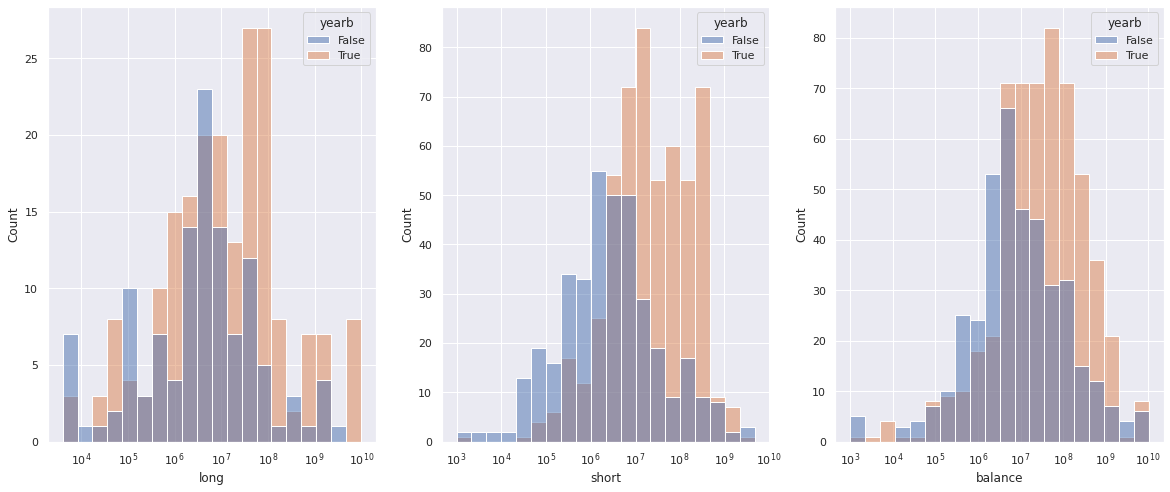

In [102]:
plt.figure(figsize=(20, 8))

for i, col in enumerate(['long', 'short', 'balance']):
    plt.subplot(131 + i)
    sns.histplot(df_acc[df_acc[col] > 0], x=col, log_scale=True, hue=(df_acc['yearb'] > 0), bins=20)

plt.show()

Компании, претерпевшие банкротство, большую часть времени имеют размер задолженности и размер баланса в среднем на 1-2 порядка выше, чем финансово здоровые компании.

### long, short, balance = 0

Посмотрим, как обстоят дела при нулевом балансе или нулевой задолженности.

In [103]:
disp(df_acc[(df_acc['long'] == 0) & (df_acc['yearb'] == 0)].shape[0] / df_acc.shape[0])
disp(df_acc[(df_acc['long'] == 0) & (df_acc['yearb'] > 0)].shape[0] / df_acc.shape[0])
disp(df_acc[(df_acc['short'] == 0) & (df_acc['yearb'] == 0)].shape[0] / df_acc.shape[0])
disp(df_acc[(df_acc['short'] == 0) & (df_acc['yearb'] > 0)].shape[0] / df_acc.shape[0])
disp(df_acc[(df_acc['balance'] == 0) & (df_acc['yearb'] == 0)].shape[0] / df_acc.shape[0])

0.282183316168898

0.38722966014418125

0.02059732234809475

0.04737384140061792

0.0

У необанкротившихся компаний долгосрочная задолженность отсутствовала в среднем на протяжении 28% времени своей деятельности, а у обанкротившихся - на протяжении 39% времени.

У необанкротившихся компаний краткосрочная задолженность отсутствовала в среднем на протяжении 2% времени своей деятельности, а у обанкротившихся - на протяжении 5% времени.

Нулевой баланс бывает только при банкротстве.

### Вывод

Обанкротившиеся компании использовали заёмные средства реже, но в больших объёмах.

Возможно, обанкротившиеся в конечном счёте компании привлекали средства в попытках спасти финансовое положение или просто брали на себя слишком высокие риски в ходе своей деятельности. В то время как здоровые компании, вероятно, привлекали деньги преимущественно на своё нормальное развитие.

## Таблица court cases

In [104]:
df_court.head(3)

,inn,resultType,caseDate,caseType,sum,isActive,currentInstance,instanceDate,case_sides
0,1001003743,1,2020-06-26,6,1459183.0,0,АС Республики Карелия,2021-07-07,0
1,1001003743,2,2014-03-31,6,79200.0,0,АС Республики Карелия,2014-07-10,0
2,1001003743,1,2010-12-20,5,0.0,0,АС Республики Карелия,2012-02-02,0


Добавим столбец о банкротстве в таблицу df_court.

In [105]:
df_court = df_court.merge(df_bank, on='inn', how='left').fillna(0)
df_court['yearb'] = df_court['yearb'].astype('int')
df_court.head(3)

,inn,resultType,caseDate,caseType,sum,isActive,currentInstance,instanceDate,case_sides,yearb
0,1001003743,1,2020-06-26,6,1459183.0,0,АС Республики Карелия,2021-07-07,0,0
1,1001003743,2,2014-03-31,6,79200.0,0,АС Республики Карелия,2014-07-10,0,0
2,1001003743,1,2010-12-20,5,0.0,0,АС Республики Карелия,2012-02-02,0,0


### currentInstance

Посмотрим, по каким компаниям судебные разбирательства происходят чаще, - по обанкротившимся или нет.

In [106]:
(
    (df_court['yearb'] > 0).groupby(df_court['currentInstance']).sum()
    / (df_court['yearb'] > 0).groupby(df_court['currentInstance']).count()
).describe()

count    116.000000
mean       0.827233
std        0.274004
min        0.000000
25%        0.760453
50%        0.965749
75%        1.000000
max        1.000000
Name: yearb, dtype: float64

Судебные разбирательства происходят чаще по компаниям, которые в большинстве случаев либо станут банкротами, либо уже ими стали. В половине судебных инстанций рассматриваются дела практически только таких компаний.

### sum

Посмотрим, как различаются суммы исков в зависимости от факта банкротства.

In [107]:
df_court.pivot_table(
    values='sum',
    columns=[(df_court['yearb'] > 0)],
    aggfunc=['count', 'mean'],
)

count                mean              
yearb False  True         False          True
sum    1416  5926  2.188472e+07  6.987951e+07

Компании-банкроты и компании, которые станут таковыми в будущем, судятся в среднем в вчетверо чаще и на втрое большие суммы.

Посмотрим подробнее.

In [108]:
disp(
    df_court[
        df_court['yearb'] < df_court['caseDate'].dt.year
    ].pivot_table(
        values='sum',
        columns=[(df_court['yearb'] > 0)],
        aggfunc=['count', 'mean'],
    )
)

count               mean              
yearb False True         False          True
sum    1416  740  2.188472e+07  7.302900e+06

In [109]:
disp(
    df_court[
        df_court['yearb'] > df_court['caseDate'].dt.year
    ].pivot_table(
        values='sum',
        columns=[(df_court['yearb'] > 0)],
        aggfunc=['count', 'mean'],
    )
)

,count,mean
yearb,True,True
sum,4532,8.779582e+07


Когда с компанией начинают судиться уже после того, как она была объявлена банкротом, в среднем спорные суммы на порядок ниже, чем когда начинают судиться с ещё "живой" компанией. С компанией, объявленной банкротом, судятся в 6 раз реже.

### case_sides

Кодировка сторон в деле:
* 0: истец;
* 1: ответчик;
* 2: свидетель.

Посмотрим, какой стороной в деле компания является чаще в зависимости от факта банкротства.

In [110]:
disp(
    df_court[
        df_court['yearb'] < df_court['caseDate'].dt.year
    ].groupby('case_sides')['inn'].count()
)

case_sides
0    1282
1     632
2     147
3      95
Name: inn, dtype: int64

In [111]:
disp(
    df_court[
        df_court['yearb'] > df_court['caseDate'].dt.year
    ].groupby('case_sides')['inn'].count()
)

case_sides
0    1591
1    2592
2     226
3     123
Name: inn, dtype: int64

In [112]:
disp(
    df_court[
        df_court['yearb'] == 0
    ].groupby('case_sides')['inn'].count()
)

case_sides
0    901
1    318
2    112
3     85
Name: inn, dtype: int64

Обанкротившиеся компании выступают истцом вдвое чаще, чем ответчиком. Ещё не обанкротившиеся компании, но которые обанкротятся вскоре, - наоборот, чаще выступают в суде ответчиком. Финансово здоровые компании выступают истцом втрое чаще, чем ответчиком.

Вероятные причины состоят в том, что в первом случае конкурсный управляющий начинает активно взыскивать всю дебиторскую задолженность, которую только можно взыскать. А во втором случае - в предбанкротном состоянии - компания испытывает трудности с выполнением своих обязательств, и контрагенты пытаются что-то взыскать с неё. По здоровым компаниям можно сказать следующее: отсутствие финансовых проблем позволяет компании нормально исполнять свои обязательства перед контрагентами, поэтому претензии к ней предъявляют значительно реже, чем предъявляет она сама.

### resultType

Проанализируем результаты судов.

In [113]:
disp(
    df_court[
        df_court['yearb'] < df_court['caseDate'].dt.year
    ].groupby('resultType')['inn'].count()
)

resultType
0     300
1     586
2    1270
Name: inn, dtype: int64

In [114]:
disp(
    df_court[
        df_court['yearb'] > df_court['caseDate'].dt.year
    ].groupby('resultType')['inn'].count()
)

resultType
0    1154
1     612
2    2766
Name: inn, dtype: int64

In [115]:
disp(
    df_court[
        df_court['yearb'] == 0
    ].groupby('resultType')['inn'].count()
)

resultType
0    156
1    458
2    802
Name: inn, dtype: int64

Проблемные компании (уже претерпевшие банкротство или будущие банкроты). Видно, что истец выигрывает в суд примерно вдвое чаще, чем ответчик. В первом случае - обанкротившаяся компания-истец, во втором случае - контрагенты-кредиторы. Вместе с тем, необходимо отметить, что ещё больше случаев так или иначе не завершились выигрышем ни для одной из сторон спора. А решения не в пользу истца сами по себе не так уж и редки.

Финансово здоровые компании выигрывают дела втрое чаще, чем проблемные.

### caseType

Проанализируем категории дел.

In [116]:
disp(
    df_court[
        df_court['yearb'] < df_court['caseDate'].dt.year
    ].groupby('caseType')['inn'].count()
)

caseType
1       98
3        1
4        7
5      317
6     1718
73       3
90      12
Name: inn, dtype: int64

In [117]:
disp(
    df_court[
        df_court['yearb'] > df_court['caseDate'].dt.year
    ].groupby('caseType')['inn'].count()
)

caseType
1      328
3       33
4        5
5      504
6     3538
73       3
90     121
Name: inn, dtype: int64

In [118]:
disp(
    df_court[
        df_court['yearb'] == 0
    ].groupby('caseType')['inn'].count()
)

caseType
1       73
3        1
4        5
5      217
6     1110
73       2
90       8
Name: inn, dtype: int64

In [119]:
df_caseType_names

{'6': 'экономические споры по гражданским правоотношениям',
 '5': 'экономические споры по административным правоотношениям',
 '90': 'не определено',
 '1': 'о несостоятельности (банкротстве) организаций и граждан',
 '73': 'об административных правонарушениях',
 '3': 'об оспаривании решений трет. судов и о выдаче исп. листов на принудительное исполнение решений трет. судов',
 '4': 'об установлении фактов, имеющих юридическое значение'}

В целом, распределения типов дел примерно совпадают у всех трёх подвыборок (учитывая разные размеры подвыборок). Отдельные категории дел различаются по количеству в 10...30 раз, но, учитывая, что абсолютное число таких случаев невелико, правильнее в данном случае говорить о выбросах и не придавать этому большое значение.

### Вывод

По тем или иным причинам в судебных спорах в 4 раза чаще участвуют компании-банкроты (в том числе - будущие). При этом они бывают как истцом, так и ответчиком: преимущественной стороны нет. Спорные суммы в делах с участием необанкроченных компаний выше в среднем в 10 раз, чем с участием обанкроченных.

Истец выигрывает дело в 2-3 раза чаще, чем ответчик. Но количество дел, где исход не определён, в среднем в 1,4 раза больше, чем тех, где решение принято хотя бы частично.

# Feature extraction

In [120]:
disp(df_acc.head(3))
disp(df_court.head(3))

,inn,year,long,short,balance,yearb
0,2465002653,2012,0.0,113756000.0,122240000.0,2021
1,3505003270,2012,21461000.0,20211000.0,81132000.0,0
2,3517003250,2012,0.0,0.0,48063000.0,2017


,inn,resultType,caseDate,caseType,sum,isActive,currentInstance,instanceDate,case_sides,yearb
0,1001003743,1,2020-06-26,6,1459183.0,0,АС Республики Карелия,2021-07-07,0,0
1,1001003743,2,2014-03-31,6,79200.0,0,АС Республики Карелия,2014-07-10,0,0
2,1001003743,1,2010-12-20,5,0.0,0,АС Республики Карелия,2012-02-02,0,0


Датасет для обучения модели будем формировать относительно компаний в целом. Т.е. одна строка - одна компания (ИНН).

Данные о бухгалтерской отчётности представляют собой временные ряды, которые имеют неодинаковую длину в разрезе компаний. Поэтому в датасете будут использоваться их агрегированные представления. При этом проходить ряды скользящим окном необходимости нет, так как они - достаточно короткие. Таким образом, вычисляя статистики, мы получим не ряды, а константы (как будто окно - размером во весь ряд).

Данные о судах, несмотря на привязку событий ко времени, не являются временными рядами по двум причинам: неравномерный интервал между наблюдениями; отсутствие протекающего во времени процесса. Дата события здесь является просто одной из характеристик этого события. Поскольку количество строк (судов), приходящихся на одну компанию, не одинаково в разрезе компаний, в датасете будут использоваться агрегированные представления.

## Таблица Accounts

### Выделение временных рядов

Можно сформировать сводную таблицу, такую, как эта.

In [121]:
df_acc.pivot_table(
    values=['long', 'short', 'balance'],
    index='inn',
    aggfunc=['count', 'mean', 'std', 'max', 'min'],
).head()

count                     mean                              \
           balance long short       balance          long         short   
inn                                                                       
1001003743       8    8     8  5.411625e+06  0.000000e+00  2.520875e+06   
1020010136       4    4     4  1.133375e+07  0.000000e+00  2.803350e+07   
1203000142       4    4     4  4.820905e+08  1.428060e+08  2.644352e+08   
1302000640       3    3     3  2.807867e+07  2.465333e+06  1.479267e+07   
1411004211       6    6     6  1.371465e+08  4.245433e+07  3.476417e+07   

                     std                                      max  \
                 balance          long         short      balance   
inn                                                                 
1001003743  1.868423e+06  0.000000e+00  2.838751e+06    9481000.0   
1020010136  5.352781e+06  0.000000e+00  2.267187e+07   14769000.0   
1203000142  3.486389e+07  1.052859e+08  1.101900e+08  523849000.0   
1302000640  3.742384e+06  2.135041e+06  1.281083e+07   32400000.0   
1411004211  6.792628e+07  3.334963e+07  2.744378e+07  177828000.0   

                                              min                           
                   long        short      balance        long        short  
inn                                                                         
1001003743          0.0    8379000.0    3930000.0         0.0     260000.0  
1020010136          0.0   55297000.0    3451000.0         0.0    3900000.0  
1203000142  252652000.0  395315000.0  442374000.0  52005000.0  165670000.0  
1302000640    3698000.0   22189000.0   25918000.0         0.0          0.0  
1411004211   74399000.0   57566000.0          0.0         0.0          0.0

Но нам потребуются и другие статистики, в том числе вычисленные из продифференцированных рядов. Поэтому трансформируем исходную таблицу df_acc во временные ряды по каждой компании (inn). Количество новых таблиц - по количеству столбцов в исходной таблице.

Сформируем словарь с пустыми таблицами.

In [122]:
df_acc_ts = {}

df_acc_ts['long'] = pd.DataFrame(
    None,
    index=np.sort(df_acc['inn'].unique()),
    columns=np.sort(df_acc['year'].unique())
)
df_acc_ts['short'] = df_acc_ts['long'].copy()
df_acc_ts['balance'] = df_acc_ts['long'].copy()

df_acc_ts['long'].head(3)

,2012,2013,2014,2015,2016,2017,2018,2019,2020
1001003743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1020010136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1203000142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Заполним таблицы.

In [123]:
df_acc_inn = df_acc.set_index('inn')

for col in df_acc_ts['long'].columns:
    for key in df_acc_ts.keys():
        df_acc_ts[key][col] = df_acc_inn[df_acc_inn['year'] == col][key]

for key in df_acc_ts.keys():        
    disp(df_acc_ts[key].head(3))

,2012,2013,2014,2015,2016,2017,2018,2019,2020
1001003743,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1020010136,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN
1203000142,NaN,NaN,NaN,NaN,NaN,252652000.0,213168000.0,53399000.0,52005000.0


,2012,2013,2014,2015,2016,2017,2018,2019,2020
1001003743,1080000.0,1080000.0,296000.0,260000.0,861000.0,8379000.0,3881000.0,4330000.0,NaN
1020010136,NaN,NaN,NaN,3900000.0,16187000.0,36750000.0,55297000.0,NaN,NaN
1203000142,NaN,NaN,NaN,NaN,NaN,165670000.0,181200000.0,395315000.0,315556000.0


,2012,2013,2014,2015,2016,2017,2018,2019,2020
1001003743,4399000.0,4399000.0,6295000.0,6051000.0,4735000.0,9481000.0,4003000.0,3930000.0,NaN
1020010136,NaN,NaN,NaN,3451000.0,12526000.0,14769000.0,14589000.0,NaN,NaN
1203000142,NaN,NaN,NaN,NaN,NaN,493782000.0,468357000.0,523849000.0,442374000.0


Сформируем и заполним аналогичные таблицы, но с продифференцированными рядами.

In [124]:
df_acc_ts_diff = {}
for key in df_acc_ts.keys():
    df_acc_ts_diff[key] = df_acc_ts[key].diff(axis=1)
    
for key in df_acc_ts_diff.keys():        
    disp(df_acc_ts_diff[key].head(3))

,2012,2013,2014,2015,2016,2017,2018,2019,2020
1001003743,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1020010136,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN
1203000142,NaN,NaN,NaN,NaN,NaN,NaN,-39484000.0,-159769000.0,-1394000.0


,2012,2013,2014,2015,2016,2017,2018,2019,2020
1001003743,NaN,0.0,-784000.0,-36000.0,601000.0,7518000.0,-4498000.0,449000.0,NaN
1020010136,NaN,NaN,NaN,NaN,12287000.0,20563000.0,18547000.0,NaN,NaN
1203000142,NaN,NaN,NaN,NaN,NaN,NaN,15530000.0,214115000.0,-79759000.0


,2012,2013,2014,2015,2016,2017,2018,2019,2020
1001003743,NaN,0.0,1896000.0,-244000.0,-1316000.0,4746000.0,-5478000.0,-73000.0,NaN
1020010136,NaN,NaN,NaN,NaN,9075000.0,2243000.0,-180000.0,NaN,NaN
1203000142,NaN,NaN,NaN,NaN,NaN,NaN,-25425000.0,55492000.0,-81475000.0


### Вычисление

Создадим пустую таблицу.

In [125]:
df_acc_stat = pd.DataFrame(None, index=df_acc_ts['long'].index)
df_acc_stat.head(3)

""
1001003743
1020010136
1203000142


Вычислим статистики.

In [126]:
suffix = {
    0: '',
    1: '_diff',
}
for i, dframe in enumerate((df_acc_ts, df_acc_ts_diff)):
    sfx = suffix[i]
    for key in df_acc_ts.keys():
        df_acc_stat.loc[:, f'{key}{sfx}_count'] = dframe[key].count(axis=1)
        df_acc_stat.loc[:, f'{key}{sfx}_mean'] = dframe[key].mean(axis=1)
        df_acc_stat.loc[:, f'{key}{sfx}_std'] = dframe[key].std(axis=1)
        df_acc_stat.loc[:, f'{key}{sfx}_max'] = dframe[key].max(axis=1)
        df_acc_stat.loc[:, f'{key}{sfx}_min'] = dframe[key].min(axis=1)
        df_acc_stat.loc[:, f'{key}{sfx}_incr'] = dframe[key].apply(
            lambda x: x.is_monotonic_increasing, axis=1
        )
        df_acc_stat.loc[:, f'{key}{sfx}_decr'] = dframe[key].apply(
            lambda x: x.is_monotonic_decreasing, axis=1
        )
        df_acc_stat[f'{key}{sfx}_incr'] = (
            df_acc_stat[f'{key}{sfx}_incr']
            .where(df_acc_stat[f'{key}{sfx}_incr'] == True, 0)
            .where(df_acc_stat[f'{key}{sfx}_incr'] == False, 1)
        )
        df_acc_stat[f'{key}{sfx}_decr'] = (
            df_acc_stat[f'{key}{sfx}_decr']
            .where(df_acc_stat[f'{key}{sfx}_decr'] == True, 0)
            .where(df_acc_stat[f'{key}{sfx}_decr'] == False, 1)
        )
df_acc_stat = df_acc_stat.merge(
    df_acc.drop_duplicates('inn').set_index('inn')['yearb'],
    left_index=True,
    right_index=True,
    how='outer',
)

disp(df_acc_stat.head(3))
disp(df_acc_stat.shape)

,long_count,long_mean,long_std,long_max,long_min,long_incr,long_decr,short_count,short_mean,short_std,short_max,short_min,short_incr,short_decr,balance_count,balance_mean,balance_std,balance_max,balance_min,balance_incr,balance_decr,long_diff_count,long_diff_mean,long_diff_std,long_diff_max,long_diff_min,long_diff_incr,long_diff_decr,short_diff_count,short_diff_mean,short_diff_std,short_diff_max,short_diff_min,short_diff_incr,short_diff_decr,balance_diff_count,balance_diff_mean,balance_diff_std,balance_diff_max,balance_diff_min,balance_diff_incr,balance_diff_decr,yearb
1001003743,8,0.0,0.000000e+00,0.0,0.0,0,0,8,2520875.0,2.838751e+06,8379000.0,260000.0,0,0,8,5411625.0,1.868423e+06,9481000.0,3930000.0,0,0,7,0.000000e+00,0.000000e+00,0.0,0.0,0,0,7,4.642857e+05,3.568897e+06,7518000.0,-4498000.0,0,0,7,-6.700000e+04,3.106260e+06,4746000.0,-5478000.0,0,0,0
1020010136,4,0.0,0.000000e+00,0.0,0.0,0,0,4,28033500.0,2.267187e+07,55297000.0,3900000.0,0,0,4,11333750.0,5.352781e+06,14769000.0,3451000.0,0,0,3,0.000000e+00,0.000000e+00,0.0,0.0,0,0,3,1.713233e+07,4.315554e+06,20563000.0,12287000.0,0,0,3,3.712667e+06,4.799343e+06,9075000.0,-180000.0,0,0,2018
1203000142,4,142806000.0,1.052859e+08,252652000.0,52005000.0,0,0,4,264435250.0,1.101900e+08,395315000.0,165670000.0,0,0,4,482090500.0,3.486389e+07,523849000.0,442374000.0,0,0,3,-6.688233e+07,8.266596e+07,-1394000.0,-159769000.0,0,0,3,4.996200e+07,1.499322e+08,214115000.0,-79759000.0,0,0,3,-1.713600e+07,6.885870e+07,55492000.0,-81475000.0,0,0,2020


(154, 43)

Удалим столбцы с нулевым стандартным отклонением (т.е. одинаковые для всех строк и, следовательно, не имеющие смысла для модели).

In [127]:
df_acc_stat.columns[df_acc_stat.std() == 0]

Index(['short_incr', 'short_decr', 'long_diff_incr', 'long_diff_decr',
       'short_diff_incr', 'short_diff_decr', 'balance_diff_incr',
       'balance_diff_decr'],
      dtype='object')

In [128]:
df_acc_stat = df_acc_stat.drop(
    columns=df_acc_stat.columns[df_acc_stat.std() == 0]
)

df_acc_stat.shape

(154, 35)

### Приведение типов

Выполним приведение типов.

In [129]:
obj_cols = df_acc_stat.columns[
    df_acc_stat.columns.str.contains('_incr')
    | df_acc_stat.columns.str.contains('_decr')
]

obj_cols

Index(['long_incr', 'long_decr', 'balance_incr', 'balance_decr'], dtype='object')

In [130]:
df_acc_stat[obj_cols] = df_acc_stat[obj_cols].astype('category')

## Таблица Court cases

### Выбор агрегированных величин

In [131]:
disp(df_court.head(3))

,inn,resultType,caseDate,caseType,sum,isActive,currentInstance,instanceDate,case_sides,yearb
0,1001003743,1,2020-06-26,6,1459183.0,0,АС Республики Карелия,2021-07-07,0,0
1,1001003743,2,2014-03-31,6,79200.0,0,АС Республики Карелия,2014-07-10,0,0
2,1001003743,1,2010-12-20,5,0.0,0,АС Республики Карелия,2012-02-02,0,0


Создадим пустую таблицу.

In [132]:
df_court_agg = pd.DataFrame(
    None,
    index = np.sort(df_court['inn'].unique()),
    columns = [
        'court_count',
        'resultType_0_frac',
        'resultType_1_frac',
        'resultType_2_frac',
        'duration_median',
        'caseType_1_frac',
        'caseType_5_frac',
        'caseType_6_frac',
        'caseType_other_frac',
        'sum_median',
        'sum_std',
        'sum_max',
        'sum_min',
        'instances_unique_amount',
        'case_side_0_frac',
        'case_side_1_frac',
        'case_side_2_frac',
        'case_side_3_frac',
    ]
)

disp(df_court_agg.shape)
disp(df_court_agg.head(3))

(154, 18)

,court_count,resultType_0_frac,resultType_1_frac,resultType_2_frac,duration_median,caseType_1_frac,caseType_5_frac,caseType_6_frac,caseType_other_frac,sum_median,sum_std,sum_max,sum_min,instances_unique_amount,case_side_0_frac,case_side_1_frac,case_side_2_frac,case_side_3_frac
1001003743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1020010136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1203000142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Вычисление

Заполним таблицу.

In [133]:
# Amount of the court cases
df_court_agg.loc[:, 'court_count'] = df_court['inn'].value_counts().sort_index()

# Result type
for d in [0, 1, 2]:
    df_court_agg.loc[:, f'resultType_{d}_frac'] = df_court[
        df_court['resultType'] == d
    ].groupby('inn').count().sort_index()['resultType'] / df_court_agg['court_count']

# Court duration - timedelta between caseDate and instanceDate
df_court_agg.loc[:, 'duration_median'] = (
    df_court['instanceDate'] - df_court['caseDate']
).groupby(df_court['inn']).median().dt.days.sort_index()

# Case type
for d in [1, 5, 6]:
    df_court_agg.loc[:, f'caseType_{d}_frac'] = df_court[
        df_court['caseType'] == d
    ].groupby('inn').count().sort_index()['caseType'] / df_court_agg['court_count']
df_court_agg.loc[:, 'caseType_other_frac'] = df_court[
    (df_court['caseType'] != 1) & (df_court['caseType'] != 5) & (df_court['caseType'] != 6)
].groupby('inn').count().sort_index()['caseType'] / df_court_agg['court_count']

# Sum aggregation
for agg_method in ['median', 'std', 'max', 'min']:
    df_court_agg.loc[:, f'sum_{agg_method}'] = df_court['sum'].groupby(df_court['inn']).agg(agg_method).sort_index()

# Amount of the unique court instances within a court case
df_court_agg.loc[:, 'instances_unique_amount'] = df_court['currentInstance'].groupby(df_court['inn']).agg(
    lambda x: np.unique(x).shape[0]
).sort_index()

# The company case side
for d in [1, 5, 6]:
    df_court_agg.loc[:, f'case_side_{d}_frac'] = df_court[
        df_court['case_sides'] == d
    ].groupby('inn').count().sort_index()['case_sides'] / df_court_agg['court_count']

disp(df_court_agg.head(10))

,court_count,resultType_0_frac,resultType_1_frac,resultType_2_frac,duration_median,caseType_1_frac,caseType_5_frac,caseType_6_frac,caseType_other_frac,sum_median,sum_std,sum_max,sum_min,instances_unique_amount,case_side_0_frac,case_side_1_frac,case_side_2_frac,case_side_3_frac,case_side_5_frac,case_side_6_frac
1001003743,4,NaN,0.500000,0.500000,318,NaN,0.500000,0.500000,NaN,39600.000,7.173637e+05,1.459183e+06,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN
1020010136,71,0.309859,0.084507,0.605634,104,0.042254,0.056338,0.901408,NaN,262911.650,3.896738e+06,3.265126e+07,0.0,3,NaN,0.802817,NaN,NaN,NaN,NaN
1203000142,403,0.186104,0.119107,0.694789,82,0.062035,0.245658,0.637717,0.054591,72000.000,5.032573e+07,6.828251e+08,0.0,19,NaN,0.493797,NaN,NaN,NaN,NaN
1302000640,9,0.222222,NaN,0.777778,50,0.222222,0.333333,0.444444,NaN,500.000,1.330725e+06,3.900000e+06,0.0,1,NaN,0.666667,NaN,NaN,NaN,NaN
1411004211,19,0.631579,0.157895,0.210526,92,0.105263,NaN,0.894737,NaN,1601064.050,1.631071e+07,7.033098e+07,0.0,5,NaN,0.736842,NaN,NaN,NaN,NaN
1429006530,82,0.500000,0.073171,0.426829,94,0.085366,0.060976,0.853659,NaN,790079.270,4.609488e+07,3.419533e+08,0.0,4,NaN,0.792683,NaN,NaN,NaN,NaN
1435087440,12,0.083333,0.166667,0.750000,53,0.250000,0.333333,0.416667,NaN,84526.000,6.261372e+07,2.173791e+08,0.0,3,NaN,0.333333,NaN,NaN,NaN,NaN
1508000122,42,0.285714,0.023810,0.690476,95,0.023810,0.238095,0.738095,NaN,234428.215,5.241184e+05,2.434724e+06,0.0,2,NaN,0.928571,NaN,NaN,NaN,NaN
1514013426,141,0.347518,0.418440,0.234043,31,0.035461,0.063830,0.900709,NaN,48251.400,3.728446e+06,2.244041e+07,0.0,3,NaN,0.390071,NaN,NaN,NaN,NaN
1609004518,8,NaN,NaN,1.000000,170,0.250000,0.250000,0.500000,NaN,223705.500,2.961340e+06,8.588954e+06,0.0,1,NaN,0.500000,NaN,NaN,NaN,NaN


### Заполнение пропусков

Рассмотрим пропуски.

In [134]:
df_court_agg.isna().any(axis=0)

court_count                False
resultType_0_frac           True
resultType_1_frac           True
resultType_2_frac           True
duration_median            False
caseType_1_frac             True
caseType_5_frac             True
caseType_6_frac             True
caseType_other_frac         True
sum_median                 False
sum_std                     True
sum_max                    False
sum_min                    False
instances_unique_amount    False
case_side_0_frac            True
case_side_1_frac            True
case_side_2_frac            True
case_side_3_frac            True
case_side_5_frac            True
case_side_6_frac            True
dtype: bool

In [135]:
df_court_agg[df_court_agg['sum_std'].isna()]['court_count'].unique()

array([1])

Столбец со стандартным отклонением суммы содержит пропуски только в тех случаях, когда имеется только одно значение суммы (единственная строка по компании), и стандартное отклонение рассчитать нельзя. Принимаем, что единственное значение суммы имеет нулевое отклонение, т.е. не отклоняется само от себя.

Остальные пропуски - в столбцах с долями значений переменных (fraction). Пропуск в этих случаях означает нулевую долю и возник вследствие отсутствия числителя.

Таким образом, все пропуски необходимо заполнить нулями.

In [136]:
df_court_agg = df_court_agg.fillna(0)

## Объединение таблиц

Посмотрим на агрегированные таблицы в финальном виде. Необходимо их объединить и получить в результате единую таблицу со всеми возможными признаками.

In [137]:
disp(df_acc_stat.head(3))
disp(df_acc_stat.shape)
disp(df_court_agg.head(3))
disp(df_court_agg.shape)

,long_count,long_mean,long_std,long_max,long_min,long_incr,long_decr,short_count,short_mean,short_std,short_max,short_min,balance_count,balance_mean,balance_std,balance_max,balance_min,balance_incr,balance_decr,long_diff_count,long_diff_mean,long_diff_std,long_diff_max,long_diff_min,short_diff_count,short_diff_mean,short_diff_std,short_diff_max,short_diff_min,balance_diff_count,balance_diff_mean,balance_diff_std,balance_diff_max,balance_diff_min,yearb
1001003743,8,0.0,0.000000e+00,0.0,0.0,0,0,8,2520875.0,2.838751e+06,8379000.0,260000.0,8,5411625.0,1.868423e+06,9481000.0,3930000.0,0,0,7,0.000000e+00,0.000000e+00,0.0,0.0,7,4.642857e+05,3.568897e+06,7518000.0,-4498000.0,7,-6.700000e+04,3.106260e+06,4746000.0,-5478000.0,0
1020010136,4,0.0,0.000000e+00,0.0,0.0,0,0,4,28033500.0,2.267187e+07,55297000.0,3900000.0,4,11333750.0,5.352781e+06,14769000.0,3451000.0,0,0,3,0.000000e+00,0.000000e+00,0.0,0.0,3,1.713233e+07,4.315554e+06,20563000.0,12287000.0,3,3.712667e+06,4.799343e+06,9075000.0,-180000.0,2018
1203000142,4,142806000.0,1.052859e+08,252652000.0,52005000.0,0,0,4,264435250.0,1.101900e+08,395315000.0,165670000.0,4,482090500.0,3.486389e+07,523849000.0,442374000.0,0,0,3,-6.688233e+07,8.266596e+07,-1394000.0,-159769000.0,3,4.996200e+07,1.499322e+08,214115000.0,-79759000.0,3,-1.713600e+07,6.885870e+07,55492000.0,-81475000.0,2020


(154, 35)

,court_count,resultType_0_frac,resultType_1_frac,resultType_2_frac,duration_median,caseType_1_frac,caseType_5_frac,caseType_6_frac,caseType_other_frac,sum_median,sum_std,sum_max,sum_min,instances_unique_amount,case_side_0_frac,case_side_1_frac,case_side_2_frac,case_side_3_frac,case_side_5_frac,case_side_6_frac
1001003743,4,0.000000,0.500000,0.500000,318,0.000000,0.500000,0.500000,0.000000,39600.00,7.173637e+05,1.459183e+06,0.0,2,0,0.000000,0,0,0.0,0.0
1020010136,71,0.309859,0.084507,0.605634,104,0.042254,0.056338,0.901408,0.000000,262911.65,3.896738e+06,3.265126e+07,0.0,3,0,0.802817,0,0,0.0,0.0
1203000142,403,0.186104,0.119107,0.694789,82,0.062035,0.245658,0.637717,0.054591,72000.00,5.032573e+07,6.828251e+08,0.0,19,0,0.493797,0,0,0.0,0.0


(154, 20)

Объединим таблицы.

In [138]:
np.all(df_acc_stat.index.values == df_court_agg.index.values)

True

In [139]:
df_feat = df_acc_stat.merge(
    df_court_agg, left_index=True, right_index=True, how='left'
).fillna(0)

disp(df_feat.head(3))
disp(df_feat.shape)

,long_count,long_mean,long_std,long_max,long_min,long_incr,long_decr,short_count,short_mean,short_std,short_max,short_min,balance_count,balance_mean,balance_std,balance_max,balance_min,balance_incr,balance_decr,long_diff_count,long_diff_mean,long_diff_std,long_diff_max,long_diff_min,short_diff_count,short_diff_mean,short_diff_std,short_diff_max,short_diff_min,balance_diff_count,balance_diff_mean,balance_diff_std,balance_diff_max,balance_diff_min,yearb,court_count,resultType_0_frac,resultType_1_frac,resultType_2_frac,duration_median,caseType_1_frac,caseType_5_frac,caseType_6_frac,caseType_other_frac,sum_median,sum_std,sum_max,sum_min,instances_unique_amount,case_side_0_frac,case_side_1_frac,case_side_2_frac,case_side_3_frac,case_side_5_frac,case_side_6_frac
1001003743,8,0.0,0.000000e+00,0.0,0.0,0,0,8,2520875.0,2.838751e+06,8379000.0,260000.0,8,5411625.0,1.868423e+06,9481000.0,3930000.0,0,0,7,0.000000e+00,0.000000e+00,0.0,0.0,7,4.642857e+05,3.568897e+06,7518000.0,-4498000.0,7,-6.700000e+04,3.106260e+06,4746000.0,-5478000.0,0,4,0.000000,0.500000,0.500000,318,0.000000,0.500000,0.500000,0.000000,39600.00,7.173637e+05,1.459183e+06,0.0,2,0,0.000000,0,0,0.0,0.0
1020010136,4,0.0,0.000000e+00,0.0,0.0,0,0,4,28033500.0,2.267187e+07,55297000.0,3900000.0,4,11333750.0,5.352781e+06,14769000.0,3451000.0,0,0,3,0.000000e+00,0.000000e+00,0.0,0.0,3,1.713233e+07,4.315554e+06,20563000.0,12287000.0,3,3.712667e+06,4.799343e+06,9075000.0,-180000.0,2018,71,0.309859,0.084507,0.605634,104,0.042254,0.056338,0.901408,0.000000,262911.65,3.896738e+06,3.265126e+07,0.0,3,0,0.802817,0,0,0.0,0.0
1203000142,4,142806000.0,1.052859e+08,252652000.0,52005000.0,0,0,4,264435250.0,1.101900e+08,395315000.0,165670000.0,4,482090500.0,3.486389e+07,523849000.0,442374000.0,0,0,3,-6.688233e+07,8.266596e+07,-1394000.0,-159769000.0,3,4.996200e+07,1.499322e+08,214115000.0,-79759000.0,3,-1.713600e+07,6.885870e+07,55492000.0,-81475000.0,2020,403,0.186104,0.119107,0.694789,82,0.062035,0.245658,0.637717,0.054591,72000.00,5.032573e+07,6.828251e+08,0.0,19,0,0.493797,0,0,0.0,0.0


(154, 55)

# Modelling

## Выбор метрик

Для оценки качества модели будем использовать следующие метрики:
* ROC-AUC;
* accuracy;
* confusion matrix.

ROC-AUC позволяет оценить, насколько точно при различных порогах определяется положительный класс (т.е. сколько из всех истинно положительных элементов модель смогла верно определить) и насколько много отрицательного класса при этом ошибочно определено как положительный (т.е. сколько из всех истинно отрицательных элементов модель ошибочно определила как положительные). Это даёт косвенное представление о степени уверенности модели. Если модель хорошо работает только в узком диапазоне порогов, то классы разделены не "уверенно": вероятности лежат по "правильные" стороны от порога (чаще всего 0.5), но слишком близко к нему. Смещаем порог - классы "поплыли". Точность такой модели будет нестабильной, но понять мы это сможем итерационно, пробуя смещать порог или обучая несколько моделей. А по ROC-AUC проблема проявится сразу.

Accuracy - точность - позволяет оценить долю правильно предсказанных классов. Хорошо работает только на сбалансированных выборках. Наша выборка (забегая вперёд) - сбалансированная, поэтому мы применим эту метрику. Также мы её применим для проверки адекватности модели: рассчитаем точность для константных моделей (все предсказания равны нулю; единице).

Confusion matrix позволяет явно оценить долю ложноположительных и долю ложноотрицательных ответов. Доли верных ответов эта метрика тоже позволяет оценить, но в нашей задаче важны первые две из перечисленных. Поскольку речь идёт о предсказании банкротства компании (а с будущим банкротом дел лучше не иметь), нам предпочтительнее снижать долю ложноотрицательных ответов ценой увеличения доли ложноположительных, чем наоборот. Если мы выдадим кредит компании, которая затем обанкротится, мы потеряем деньги, и это необратимо. А если ошибочно откажем здоровой компании, то потеряем только будущую прибыль и останемся при своих. И это в некотором смысле обратимо, так как можно эти деньги позже выдать другой компании или, например, эту же компанию рассмотреть повнимательнее ещё раз.

## Выделение целевого признака

Необходимо спрогнозировать вероятность банкротства компании. Это - задача бинарной классификации, где требуется предсказать вероятность положительного класса.

Целевой признак - факт банкротства. Создадим его из столбца yearb (год наступления банкротства), заменив в нём все ненулевые значения на единицы.

In [140]:
df_feat['Y'] = df_feat['yearb'].where(df_feat['yearb'] == 0, 1)
df_feat = df_feat.drop(columns='yearb').reset_index(drop=True)
df_feat.head(3)

,long_count,long_mean,long_std,long_max,long_min,long_incr,long_decr,short_count,short_mean,short_std,short_max,short_min,balance_count,balance_mean,balance_std,balance_max,balance_min,balance_incr,balance_decr,long_diff_count,long_diff_mean,long_diff_std,long_diff_max,long_diff_min,short_diff_count,short_diff_mean,short_diff_std,short_diff_max,short_diff_min,balance_diff_count,balance_diff_mean,balance_diff_std,balance_diff_max,balance_diff_min,court_count,resultType_0_frac,resultType_1_frac,resultType_2_frac,duration_median,caseType_1_frac,caseType_5_frac,caseType_6_frac,caseType_other_frac,sum_median,sum_std,sum_max,sum_min,instances_unique_amount,case_side_0_frac,case_side_1_frac,case_side_2_frac,case_side_3_frac,case_side_5_frac,case_side_6_frac,Y
0,8,0.0,0.000000e+00,0.0,0.0,0,0,8,2520875.0,2.838751e+06,8379000.0,260000.0,8,5411625.0,1.868423e+06,9481000.0,3930000.0,0,0,7,0.000000e+00,0.000000e+00,0.0,0.0,7,4.642857e+05,3.568897e+06,7518000.0,-4498000.0,7,-6.700000e+04,3.106260e+06,4746000.0,-5478000.0,4,0.000000,0.500000,0.500000,318,0.000000,0.500000,0.500000,0.000000,39600.00,7.173637e+05,1.459183e+06,0.0,2,0,0.000000,0,0,0.0,0.0,0
1,4,0.0,0.000000e+00,0.0,0.0,0,0,4,28033500.0,2.267187e+07,55297000.0,3900000.0,4,11333750.0,5.352781e+06,14769000.0,3451000.0,0,0,3,0.000000e+00,0.000000e+00,0.0,0.0,3,1.713233e+07,4.315554e+06,20563000.0,12287000.0,3,3.712667e+06,4.799343e+06,9075000.0,-180000.0,71,0.309859,0.084507,0.605634,104,0.042254,0.056338,0.901408,0.000000,262911.65,3.896738e+06,3.265126e+07,0.0,3,0,0.802817,0,0,0.0,0.0,1
2,4,142806000.0,1.052859e+08,252652000.0,52005000.0,0,0,4,264435250.0,1.101900e+08,395315000.0,165670000.0,4,482090500.0,3.486389e+07,523849000.0,442374000.0,0,0,3,-6.688233e+07,8.266596e+07,-1394000.0,-159769000.0,3,4.996200e+07,1.499322e+08,214115000.0,-79759000.0,3,-1.713600e+07,6.885870e+07,55492000.0,-81475000.0,403,0.186104,0.119107,0.694789,82,0.062035,0.245658,0.637717,0.054591,72000.00,5.032573e+07,6.828251e+08,0.0,19,0,0.493797,0,0,0.0,0.0,1


Посмотрим соотношение классов в выборке.

In [141]:
df_feat['Y'].value_counts(normalize=True)

1    0.61039
0    0.38961
Name: Y, dtype: float64

Имеется перевес положительного класса. Перевес - небольшой, выборку можно считать сбалансированной: такой дисбаланс любая модель "переварит" нормально без каких-либо дополнительных мероприятий.

## Разделение на выборки

Разделим датасет на две выборки: обучающую и тестовую. Размеры выборок - 0.85 и 0.15 соответственно. Во время обучения будем применять 5-fold кросс-валидацию. Разделять будем стратифицированно по целевому признаку.

In [142]:
seed = 42

df_train, df_test = train_test_split(
    df_feat, test_size=0.15, stratify=df_feat['Y'], random_state=seed
)

disp(df_train.shape[0])
disp(df_test.shape[0])

130

24

На примере кода, в котором выполняется разделение на обучающую и тестовую выборки, необходимо пояснить подход к memory-менеджменту. В данной задаче потребление памяти в абсолютном выражении невелико: датасет занимает в ней менее 1 Мб. Это позволяет подходить к memory-менеджменту упрощённо и тем самым упростить код.

В данном примере мы создали в памяти копию датасета, присвоив его части новым переменным. Дополнительными затратами памяти можно пренебречь. Однако, в общем случае так делать недопустимо, и следует работать с индексами: разделять массив индексов на части, кэшировать их и затем с их помощью брать различные срезы от датасета, который хранится в памяти в единственном экземпляре. Если датасет не помещается в памяти целиком, то подход ещё немного усложняется. А когда мы работаем с легковесными датасетами, как в нашей задаче, то, наоборот, всё можно упростить.

## Baseline

Для создания модели будет использоваться алгоритм LightGBM. Как и любой другой алгоритм, основанный на деревьях, он хорошо работает с категориальными переменными, а в нашем датасете они будут. При этом LightGBM, в отличие, например, от Случайного леса, значительно быстрее обучается и показывает более высокие результаты.

Сделаем бейзлайн - обучим и протестируем модель.

### Гиперпараметры

Набор гиперпараметров разделим на две части. Параметры из первой части будем перебирать. Параметры из второй части (с суффиксом common) - условно постоянные.

In [143]:
params_lgbm_basic = {
    "max_depth": 8,
    "num_leaves": 2 ** 8,
    "max_bin": 2 ** 6 - 1,
    "min_child_samples": 16,
    
    "num_iterations": 100,
    "learning_rate": 0.02,
}

In [144]:
params_lgbm_common = {
    "objective": 'binary',
    "boost_from_average": False,
    "seed": 42,
    "verbosity": -1,
    "num_threads": 4,
    "feature_fraction": 0.75,
    "drop_rate": 0.5,
    "skip_drop": 0.2,
}

In [145]:
params_lgbm_basic.update(params_lgbm_common)

### Признаки

Создадим списки признаков (имён столбцов), которые будем непосредственно подавать в модель.

В бейзлайн подадим все имеющиеся признаки.

In [146]:
feature_names_all = df_train.columns[df_train.columns.isin(['Y']) != True]

In [147]:
feature_names_base_allfeatures = feature_names_all.copy()
feature_names_base_allfeatures

Index(['long_count', 'long_mean', 'long_std', 'long_max', 'long_min',
       'long_incr', 'long_decr', 'short_count', 'short_mean', 'short_std',
       'short_max', 'short_min', 'balance_count', 'balance_mean',
       'balance_std', 'balance_max', 'balance_min', 'balance_incr',
       'balance_decr', 'long_diff_count', 'long_diff_mean', 'long_diff_std',
       'long_diff_max', 'long_diff_min', 'short_diff_count', 'short_diff_mean',
       'short_diff_std', 'short_diff_max', 'short_diff_min',
       'balance_diff_count', 'balance_diff_mean', 'balance_diff_std',
       'balance_diff_max', 'balance_diff_min', 'court_count',
       'resultType_0_frac', 'resultType_1_frac', 'resultType_2_frac',
       'duration_median', 'caseType_1_frac', 'caseType_5_frac',
       'caseType_6_frac', 'caseType_other_frac', 'sum_median', 'sum_std',
       'sum_max', 'sum_min', 'instances_unique_amount', 'case_side_0_frac',
       'case_side_1_frac', 'case_side_2_frac', 'case_side_3_frac',
       'case_side_5_

In [148]:
target_name = 'Y'

### Обучение

Обучение будет выполняться следующим образом:
* 5-fold кросс-валидация;
* 3 повтора, т.е разделение на фолды будет выполнено тремя разными (случайными) способами;
* 3 сида модели, т.е. каждая из 15 вышеописанных итераций будет выполнена трёхкратно при разном (случайном) начальном состоянии модели (инициализации).

Это - общий подход. Не всегда есть возможность сделать столько повторов, но при столь малом размере обучающей выборки, как у нас, такое количество повторов - необходимость. Иначе модель может оказаться сильно зависимой от способа разделения выборки и от инициализации, что приведёт к нестабильным результатам, а при проведении оптимизации гиперпараметров - ещё и к переобучению (подгонка под конкретный сид). Вместе с тем, малый размер выборки позволяет всё сделать как надо, поскольку обучение происходит очень быстро в абсолютном выражении (~ 1...2 с), и можно сделать столько повторов, сколько потребуется. В нашем случае указанного количества повторов оказалось достаточно, дальнейшее увеличение улучшает результат только на валидации, а на тесте (когда работает совокупность моделей) - нет.

Все модели сохраняются в массив и затем используются при тестировании. Итоговый результат получается простым усреднением по всем моделям.

Значение метрики при валидации (ROC-AUC) - среднее значение метрик по каждой отдельной модели.

In [149]:
models_base_allfeatures, score = ml_trainer_cv(
    df_train,
    feature_names_base_allfeatures,
    target_name,
    lgbm_algorithm,
    params_lgbm_basic,
)
print('roc_auc: {:.5f}'.format(score))

Computing... done
roc_auc: 0.93981


Сохраним модели на диск (заглушено).

In [150]:
# save_models_list(models_base_allfeatures, 'models_base_allfeatures', path_root)

### Тестирование

In [151]:
pred_proba = ml_test(
    df_test,
    df_test.index,
    feature_names_base_allfeatures,
    models_base_allfeatures,
)

Computing... done


In [152]:
print_metrics(df_test['Y'].values, pred_proba)

roc auc:  0.97778
accuracy: 0.87500
ac.const: 0.62500

confusion matrix:
[[0.25  0.125]
 [0.    0.625]]


Ложноотрицательных - нет, ложноположительных - немного. Неплохой результат.

Посмотрим, насколько хорошо модель разделяет классы.

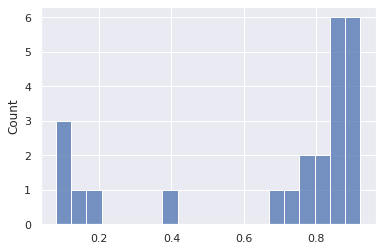

In [153]:
sns.histplot(pred_proba, bins=20)
plt.show()

Большая часть ответов модели - с высокой уверенностью (по краям диаграммы).

Посмотрим, какова минимальная уверенность в этом случае.

In [154]:
np.min(np.abs(pred_proba - 0.5))

0.11383336354681362

### Feature importances

Рассмотрим важность признаков, - на какие признаки модель при разделении классов опирается больше всего, а на какие - меньше.

In [155]:
feat_imp_allfeat = lgbm_feature_importances(models_base_allfeatures)
feat_imp_allfeat

,feature_names,split,gain
39,caseType_1_frac,90,1466
49,case_side_1_frac,56,213
9,short_std,23,154
36,resultType_1_frac,22,80
34,court_count,19,104
44,sum_std,17,51
33,balance_diff_min,17,47
43,sum_median,16,18
45,sum_max,13,39
38,duration_median,12,6


Наибольший прирост информации, на порядок больший по сравнению с другими, даёт признак caseType_1_frac. Этот признак показывает долю судебных дел категории "о несостоятельности (банкротстве) организаций и граждан". Это не утечка в прямом смысле, однако, ненулевое значение этого признака однозначно свидетельствует о том, что речь о банкротстве компании уже идёт (причём в суде), и, даже если компанию пока не признали банкротом, это тревожный звонок: финансово здоровая компания не судится по поводу банкротства. Это подтверждается данными: банкроты по признаку caseType_1_frac выявляются вполне точно.

А что будет, если мы не будем знать о таких делах? Представим, что положение компании - точно такое же, но суд о банкротстве ещё не состоялся.

## Baseline без caseType_1_frac

### Гиперпараметры

Запустим обучение с теми же гиперпараметрами, что и первый бейзлайн.

### Признаки

Уберём признак caseType_1_frac и отберём некоторое количество наиболее важных признаков.

In [156]:
amount = 30

feature_names_base_wocasetype1frac = pd.Index(
    feat_imp_allfeat.loc[feat_imp_allfeat.index[:amount], 'feature_names']
)
feature_names_base_wocasetype1frac = feature_names_base_wocasetype1frac[
    feature_names_base_wocasetype1frac.isin(['caseType_1_frac']) != True
]
feature_names_base_wocasetype1frac

Index(['case_side_1_frac', 'short_std', 'resultType_1_frac', 'court_count',
       'sum_std', 'balance_diff_min', 'sum_median', 'sum_max',
       'duration_median', 'balance_diff_mean', 'short_diff_min', 'balance_min',
       'short_max', 'long_count', 'short_mean', 'resultType_0_frac',
       'caseType_5_frac', 'short_diff_mean', 'balance_diff_std',
       'long_diff_min', 'balance_std', 'short_diff_std', 'short_diff_max',
       'short_count', 'long_diff_count', 'balance_max', 'caseType_6_frac',
       'resultType_2_frac', 'instances_unique_amount'],
      dtype='object', name='feature_names')

### Обучение

In [157]:
models_base_wocasetype1frac, score = ml_trainer_cv(
    df_train,
    feature_names_base_wocasetype1frac,
    target_name,
    lgbm_algorithm,
    params_lgbm_basic,
)
print('roc_auc: {:.5f}'.format(score))

Computing... done
roc_auc: 0.82056


Сохраним модели на диск (заглушено).

In [158]:
# save_models_list(models_base_wocasetype1frac, 'models_base_wocasetype1frac', path_root)

### Тестирование

In [159]:
pred_proba = ml_test(
    df_test,
    df_test.index,
    feature_names_base_wocasetype1frac,
    models_base_wocasetype1frac,
    silent=True,
)

print_metrics(df_test['Y'].values, pred_proba)

roc auc:  0.97037
accuracy: 0.87500
ac.const: 0.62500

confusion matrix:
[[0.25  0.125]
 [0.    0.625]]


Точность модели не изменилась. Ложноотрицательных ответов по-прежнему нет.

Разница между средним значением ROC-AUC (на валидации) и значением ROC-AUC, рассчитанным по усреднённым результатам моделей (на тестировании), - больше, чем в бейзлайне. Результат на тесте приближается к бейзлайну, несмотря на отсутствие признака caseType_1_frac. Информации, содержащейся в остальных признаках, оказалось достаточно, чтобы сделать правильные выводы, даже не зная о существовании дела о банкротстве.

Посмотрим, насколько хорошо модель разделяет классы.

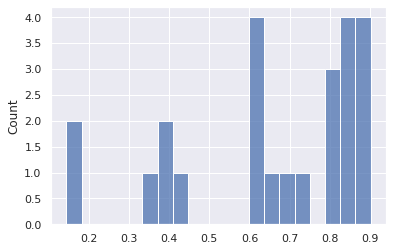

In [160]:
sns.histplot(pred_proba, bins=20)
plt.show()

Уверенность снизилась. Вероятности расположены ближе к порогу 0.5 по сравнению с первым бейзлайном, но не вплотную (минимальный модуль разности между порогом и ближайшей к нему вероятностью - более 0.05).

In [161]:
np.min(np.abs(pred_proba - 0.5))

0.08894236832828739

### Feature importances

In [162]:
feat_imp_wotype1frac = lgbm_feature_importances(models_base_wocasetype1frac)
feat_imp_wotype1frac

,feature_names,split,gain
3,court_count,50,441
0,case_side_1_frac,42,233
4,sum_std,32,181
10,short_diff_min,28,94
1,short_std,26,252
9,balance_diff_mean,22,72
16,caseType_5_frac,21,66
7,sum_max,19,175
5,balance_diff_min,15,55
13,long_count,15,42


На первых местах - количество тяжб и доля дел, где компания является ответчиком. В целом, выглядит логично: с компании всё время хотят что-то взыскать, всё ли у неё хорошо?

## Оптимизация

### Гиперпараметры

Сформируем сетку гиперпараметров, из которой затем случайным образом выберем некоторое количество наборов.

In [163]:
params_grid = {
    "max_depth": np.arange(4, 11, dtype='int'),
    "num_leaves": np.geomspace(2**4, 2**10, 7, dtype='int'),
    "max_bin": np.geomspace(2**4, 2**8, 5, dtype='int') - 1,
    "num_iterations": np.arange(50, 251, 50, dtype='int'),
    "learning_rate": np.arange(5e-3, 2.5e-2, 5e-3),
    "feature_pre_filter": [True, False],
    "min_data_in_leaf": np.arange(4, 9, dtype='int'),
    "min_sum_hessian_in_leaf": np.geomspace(1e-3, 1.0, 4),
    "min_data_in_bin": np.arange(4, 9, dtype='int'),
    "lambda_l1": np.arange(0, 3e-1, 5e-2),
    "lambda_l2": np.arange(0, 3e-1, 5e-2),
}

In [164]:
grid = ParameterGrid(params_grid)
len(grid)

35280000

Число возможных вариантов весьма внушительно, но нам будет достаточно пройти несколько сотен из них.

### Признаки

Попробуем сначала прогнать на полном наборе признаков.

In [165]:
feature_names_ensemble_allfeatures = feature_names_all.copy()
feature_names_ensemble_allfeatures

Index(['long_count', 'long_mean', 'long_std', 'long_max', 'long_min',
       'long_incr', 'long_decr', 'short_count', 'short_mean', 'short_std',
       'short_max', 'short_min', 'balance_count', 'balance_mean',
       'balance_std', 'balance_max', 'balance_min', 'balance_incr',
       'balance_decr', 'long_diff_count', 'long_diff_mean', 'long_diff_std',
       'long_diff_max', 'long_diff_min', 'short_diff_count', 'short_diff_mean',
       'short_diff_std', 'short_diff_max', 'short_diff_min',
       'balance_diff_count', 'balance_diff_mean', 'balance_diff_std',
       'balance_diff_max', 'balance_diff_min', 'court_count',
       'resultType_0_frac', 'resultType_1_frac', 'resultType_2_frac',
       'duration_median', 'caseType_1_frac', 'caseType_5_frac',
       'caseType_6_frac', 'caseType_other_frac', 'sum_median', 'sum_std',
       'sum_max', 'sum_min', 'instances_unique_amount', 'case_side_0_frac',
       'case_side_1_frac', 'case_side_2_frac', 'case_side_3_frac',
       'case_side_5_

### Обучение по сетке

Выполним перебор 200 случайно выбранных наборов гиперпараметров.

Объекты моделей кэшировать не будем во избежание переполнения памяти.

In [166]:
iterations = 200
grid_items = np.empty(iterations, dtype='object')
scores_grid = np.zeros(iterations, dtype='float')

In [167]:
for i in tqdm(np.arange(iterations)):
    grid_item = grid[np.random.randint(len(grid))]
    grid_item.update(params_lgbm_common)
    models, score = ml_trainer_cv(
        df_train,
        feature_names_ensemble_allfeatures,
        target_name,
        lgbm_algorithm,
        grid_item,
        silent=True,
    )
    grid_items[i] = grid_item
    scores_grid[i] = score

100%|██████████| 200/200 [05:43<00:00,  1.72s/it]


### Поиск лучшего решения

Найдём индексы 10 лучших результатов и посмотрим значения ROC-AUC на валидации.

In [168]:
indices_best = np.flip(np.argsort(scores_grid)[-10:])
disp(indices_best)
for idx in indices_best:
    print('roc_auc: {:.5f}'.format(scores_grid[idx]))

array([109, 102,  16, 159, 194,  11,   0,  26, 129, 103])

roc_auc: 0.95902
roc_auc: 0.95862
roc_auc: 0.95860
roc_auc: 0.95828
roc_auc: 0.95788
roc_auc: 0.95788
roc_auc: 0.95782
roc_auc: 0.95782
roc_auc: 0.95735
roc_auc: 0.95665


Рассмотрим гиперпараметры.

In [169]:
best_params_df(grid_items, indices_best)

,idx_109,idx_102,idx_16,idx_159,idx_194,idx_11,idx_0,idx_26,idx_129,idx_103
num_leaves,512,512,63,127,256,256,512,127,127,1024
num_iterations,250,150,250,200,200,250,250,250,150,200
min_sum_hessian_in_leaf,0.01,0.1,0.001,0.01,0.001,1.0,0.001,0.1,0.01,0.001
min_data_in_leaf,7,7,8,8,8,8,8,7,5,8
min_data_in_bin,7,8,7,8,8,8,4,4,4,8
max_depth,6,5,4,5,4,7,4,9,6,4
max_bin,31,31,15,15,15,15,255,255,126,126
learning_rate,0.015,0.01,0.02,0.02,0.02,0.01,0.02,0.02,0.02,0.02
lambda_l2,0.05,0.0,0.25,0.1,0.2,0.0,0.0,0.2,0.1,0.25
lambda_l1,0.05,0.05,0.15,0.2,0.15,0.0,0.15,0.15,0.0,0.05


### Обучение лучших моделей

Обучим модели с наборами гиперпараметров, которые мы отобрали на предыдущем шаге.

In [170]:
model_arrays_best = np.empty(indices_best.shape[0], dtype='object')

In [171]:
for i in tqdm(np.arange(indices_best.shape[0])):
    grid_item = grid[indices_best[i]]
    grid_item.update(params_lgbm_common)
    models, score = ml_trainer_cv(
        df_train,
        feature_names_ensemble_allfeatures,
        target_name,
        lgbm_algorithm,
        grid_item,
        silent=True,
    )
    model_arrays_best[i] = models

models_ensemble_allfeatures = form_models_list(model_arrays_best)

100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


Сохраним модели на диск (заглушено).

In [172]:
# save_models_list(models_ensemble_allfeatures, 'models_ensemble_allfeatures', path_root)

### Тестирование

Протестируем все десять наборов моделей в совокупности.

In [173]:
pred_proba = ml_test(
    df_test,
    df_test.index,
    feature_names_ensemble_allfeatures,
    models_ensemble_allfeatures,
)

Computing... done


In [174]:
print_metrics(df_test['Y'].values, pred_proba)

roc auc:  0.94074
accuracy: 0.87500
ac.const: 0.62500

confusion matrix:
[[0.25  0.125]
 [0.    0.625]]


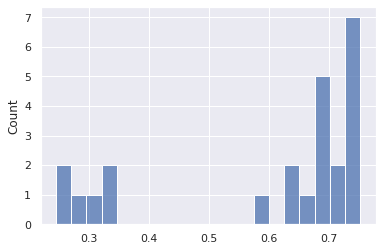

In [175]:
sns.histplot(pred_proba, bins=20)
plt.show()

По метрике ROC-AUC данные модели показали себя на валидации лучше, чем бейзлайн, а на тестировании - хуже. Возможно, этот результат окажется стабильнее на новых данных по сравнению с бейзлайном. Но также не исключено, что бейзлайн оказался очень удачным и действительно работает лучше, чем найденные по сетке модели.

Точность при тестировании не изменилась по сравнению с бейзлайном.

Характер изменений в гистограмме указывает на то, что стабильность модели повысилась. Классы разделены увереннее: вероятности лежат дальше от порога 0.5 по сравнению с бейзлайном.

In [176]:
np.min(np.abs(pred_proba - 0.5))

0.09051167666499704

### Feature importances

In [177]:
feat_imp_allfeat = lgbm_feature_importances(models)
feat_imp_allfeat

,feature_names,split,gain
39,caseType_1_frac,254,5083
49,case_side_1_frac,192,606
33,balance_diff_min,122,349
16,balance_min,115,169
36,resultType_1_frac,114,344
43,sum_median,113,104
9,short_std,99,438
34,court_count,97,368
27,short_diff_max,80,94
44,sum_std,79,220


Здесь всё осталось примерно так же, как в бейзлайне.

## Оптимизация без caseType_1_frac

### Гиперпараметры

Выполним перебор по той же сетке.

### Признаки

Уберём признак caseType_1_frac и отберём некоторое количество наиболее важных признаков.

In [178]:
amount = 30

feature_names_ensemble_wocasetype1frac = pd.Index(
    feat_imp_allfeat.loc[feat_imp_allfeat.index[:amount], 'feature_names']
)
feature_names_ensemble_wocasetype1frac = feature_names_ensemble_wocasetype1frac[
    feature_names_ensemble_wocasetype1frac.isin(['caseType_1_frac']) != True
]
feature_names_ensemble_wocasetype1frac

Index(['case_side_1_frac', 'balance_diff_min', 'balance_min',
       'resultType_1_frac', 'sum_median', 'short_std', 'court_count',
       'short_diff_max', 'sum_std', 'sum_max', 'short_mean', 'short_diff_min',
       'short_diff_mean', 'short_max', 'long_count', 'balance_diff_mean',
       'balance_std', 'caseType_5_frac', 'duration_median', 'balance_diff_max',
       'balance_diff_std', 'instances_unique_amount', 'sum_min',
       'caseType_6_frac', 'resultType_0_frac', 'balance_mean',
       'short_diff_std', 'resultType_2_frac', 'balance_max'],
      dtype='object', name='feature_names')

### Обучение по сетке

Выполним перебор 200 случайно выбранных наборов гиперпараметров.

In [179]:
iterations = 200
grid_items = np.empty(iterations, dtype='object')
scores_grid = np.zeros(iterations, dtype='float')

In [180]:
for i in tqdm(np.arange(iterations)):
    grid_item = grid[np.random.randint(len(grid))]
    grid_item.update(params_lgbm_common)
    models, score = ml_trainer_cv(
        df_train,
        feature_names_ensemble_wocasetype1frac,
        target_name,
        lgbm_algorithm,
        grid_item,
        silent=True,
    )
    grid_items[i] = grid_item
    scores_grid[i] = score

100%|██████████| 200/200 [04:23<00:00,  1.32s/it]


### Поиск лучшего решения

Найдём индексы 10 лучших результатов и посмотрим значения ROC-AUC на валидации.

In [181]:
indices_best = np.flip(np.argsort(scores_grid)[-10:])
disp(indices_best)
for idx in indices_best:
    print('roc_auc: {:.5f}'.format(scores_grid[idx]))

array([120,   7,  62,  48,  68, 183,  73,  71, 171,   0])

roc_auc: 0.85115
roc_auc: 0.85074
roc_auc: 0.85073
roc_auc: 0.84836
roc_auc: 0.84819
roc_auc: 0.84728
roc_auc: 0.84698
roc_auc: 0.84635
roc_auc: 0.84614
roc_auc: 0.84593


Рассмотрим гиперпараметры.

In [182]:
best_params_df(grid_items, indices_best)

,idx_120,idx_7,idx_62,idx_48,idx_68,idx_183,idx_73,idx_71,idx_171,idx_0
num_leaves,16,1024,1024,512,63,63,63,63,32,1024
num_iterations,100,250,100,50,150,100,200,50,250,250
min_sum_hessian_in_leaf,0.1,0.001,0.1,0.1,1.0,0.1,0.01,0.1,0.01,0.1
min_data_in_leaf,7,6,6,6,6,5,7,7,5,5
min_data_in_bin,8,8,8,8,8,8,8,8,4,6
max_depth,8,9,6,9,7,5,10,6,9,9
max_bin,15,15,15,15,15,15,15,15,126,255
learning_rate,0.02,0.005,0.02,0.015,0.015,0.01,0.015,0.01,0.015,0.02
lambda_l2,0.0,0.05,0.0,0.1,0.0,0.15,0.2,0.05,0.05,0.2
lambda_l1,0.0,0.2,0.2,0.15,0.1,0.15,0.1,0.2,0.0,0.25


### Обучение лучших моделей

Обучим модели с наборами гиперпараметров, которые мы отобрали на предыдущем шаге.

In [183]:
model_arrays_best = np.empty(indices_best.shape[0], dtype='object')

In [184]:
for i in tqdm(np.arange(indices_best.shape[0])):
    grid_item = grid[indices_best[i]]
    grid_item.update(params_lgbm_common)
    models, score = ml_trainer_cv(
        df_train,
        feature_names_ensemble_wocasetype1frac,
        target_name,
        lgbm_algorithm,
        grid_item,
        silent=True,
    )
    model_arrays_best[i] = models

models_ensemble_wocasetype1frac = form_models_list(model_arrays_best)

100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


Сохраним модели на диск (заглушено).

In [185]:
# save_models_list(models_ensemble_wocasetype1frac, 'models_ensemble_wocasetype1frac', path_root)

### Тестирование

Протестируем все десять наборов моделей в совокупности.

In [186]:
pred_proba = ml_test(
    df_test,
    df_test.index,
    feature_names_ensemble_wocasetype1frac,
    models_ensemble_wocasetype1frac,
)

Computing... done


In [187]:
print_metrics(df_test['Y'].values, pred_proba)

roc auc:  0.94074
accuracy: 0.87500
ac.const: 0.62500

confusion matrix:
[[0.25  0.125]
 [0.    0.625]]


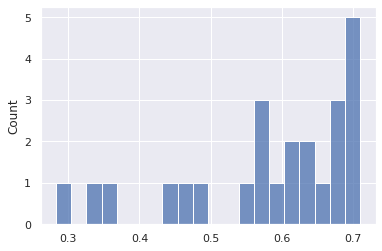

In [188]:
sns.histplot(pred_proba, bins=20)
plt.show()

По метрике ROC-AUC данные модели показали себя на валидации лучше, чем бейзлайн, а на тестировании - хуже.

Точность при тестировании не изменилась по сравнению с бейзлайном.

Гистограмма по сравнению с бейзлайном изменилась. Некоторые ответы стали увереннее (вероятности отдалились от порога 0.5), но появились и те, что стали ближе к порогу: минимальная разность уменьшилась.

In [189]:
np.min(np.abs(pred_proba - 0.5))

0.02101693921891573

### Feature importances

In [190]:
feat_imp_wotype1frac = lgbm_feature_importances(models)
feat_imp_wotype1frac

,feature_names,split,gain
6,court_count,44,541
0,case_side_1_frac,42,283
5,short_std,33,352
19,balance_diff_max,32,128
2,balance_min,29,110
8,sum_std,26,213
9,sum_max,25,363
11,short_diff_min,25,82
1,balance_diff_min,24,91
4,sum_median,22,45


Здесь всё осталось примерно так же, как в бейзлайне.

## Совмещение моделей

Попробуем совместить обе категории моделей. В случае, когда у нас есть информация о том, что дела о банкротстве имели место, будет работать один ансамбль моделей, а когда такой информации нет - другой.

### Разделение выборки

Разделим тестовую выборку на две части:
* признак caseType_1_frac больше нуля: мы знаем, что дела о банкротстве имели место;
* признак caseType_1_frac равен нулю: дел о банкротстве не было или мы о них не знаем.

In [191]:
(df_test['caseType_1_frac'] > 0).value_counts()

True     19
False     5
Name: caseType_1_frac, dtype: int64

Сформируем индексы для каждой из подвыборок.

In [192]:
index_casetype1frac_true = df_test[df_test['caseType_1_frac'] > 0].index
index_casetype1frac_false = df_test[df_test['caseType_1_frac'] == 0].index

disp(index_casetype1frac_true.shape[0])
disp(index_casetype1frac_false.shape[0])

19

5

### Базовые модели

Выполним тестирование.

In [193]:
pred_proba_casetype1frac_true = ml_test(
    df_test.loc[index_casetype1frac_true],
    index_casetype1frac_true,
    feature_names_base_allfeatures,
    models_base_allfeatures,
)

Computing... done


In [194]:
pred_proba_casetype1frac_false = ml_test(
    df_test.loc[index_casetype1frac_false],
    index_casetype1frac_false,
    feature_names_base_wocasetype1frac,
    models_base_wocasetype1frac,
)

Computing... done


Сформируем таблицу с результатами, чтобы соотнести индексы аккуратно и без ошибок.

In [195]:
results = pd.DataFrame(
    None,
    index = df_test['Y'].index,
    columns = ['true', 'pred'],
)
results.head(3)

,true,pred
65,NaN,NaN
76,NaN,NaN
80,NaN,NaN


In [196]:
results['true'] = df_test['Y']
results.loc[index_casetype1frac_true, 'pred'] = pd.Series(
    pred_proba_casetype1frac_true,
    index = index_casetype1frac_true,
)
results.loc[index_casetype1frac_false, 'pred'] = pd.Series(
    pred_proba_casetype1frac_false,
    index = index_casetype1frac_false,
)

results.head(3)

,true,pred
65,0,0.14399
76,1,0.876179
80,1,0.903464


Рассчитаем метрики и оценим результат.

In [197]:
print_metrics(results['true'].values, results['pred'].values)

roc auc:  0.97778
accuracy: 0.87500
ac.const: 0.62500

confusion matrix:
[[0.25  0.125]
 [0.    0.625]]


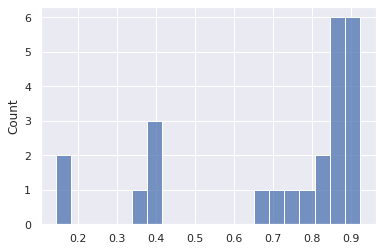

In [198]:
sns.histplot(results['pred'].values, bins=20)
plt.show()

ROC-AUC сравнялся с результатом первой базовой модели, когда имеются данные о судах о банкротстве. Но стоит ожидать, что она может быть любой из диапазона от минимального значения, когда признак caseType_1_frac отсутствует, до максимального, когда этот признак присутствует. Это зависит от соотношения количества одних и других случаев.

Точность не изменилась.

Гистограмма выглядит склееной из двух половинок. Половинки - от двух предыдущих случаев, когда мы применяем сначала одни, потом другие модели ко всей тестовой выборке сразу. Это объясняется следующим образом. Если дело о банкротстве имеет место, то в большинстве случаев компания действительно является банкротом или станет им (наблюдаемый факт). Такие строки в датасете обрабатывают модели, учитывающие признак caseType_1_frac. Результат - в правой части гистограммы. Если же дел о банкротстве у компании не было, то - наоборот. Результат - в левой части гистограммы.

In [199]:
np.min(np.abs(results['pred'].values - 0.5))

0.10067057546687253

### Ансамбли моделей

Выполним тестирование.

In [200]:
pred_proba_casetype1frac_true = ml_test(
    df_test.loc[index_casetype1frac_true],
    index_casetype1frac_true,
    feature_names_ensemble_allfeatures,
    models_ensemble_allfeatures,
)

Computing... done


In [201]:
pred_proba_casetype1frac_false = ml_test(
    df_test.loc[index_casetype1frac_false],
    index_casetype1frac_false,
    feature_names_ensemble_wocasetype1frac,
    models_ensemble_wocasetype1frac,
)

Computing... done


Сформируем таблицу с результатами.

In [202]:
results = pd.DataFrame(
    None,
    index = df_test['Y'].index,
    columns = ['true', 'pred'],
)
results.head(3)

,true,pred
65,NaN,NaN
76,NaN,NaN
80,NaN,NaN


In [203]:
results['true'] = df_test['Y']
results.loc[index_casetype1frac_true, 'pred'] = pd.Series(
    pred_proba_casetype1frac_true,
    index = index_casetype1frac_true,
)
results.loc[index_casetype1frac_false, 'pred'] = pd.Series(
    pred_proba_casetype1frac_false,
    index = index_casetype1frac_false,
)

results.head(3)

,true,pred
65,0,0.28295
76,1,0.684565
80,1,0.743156


Рассчитаем метрики и оценим результат.

In [204]:
print_metrics(results['true'].values, results['pred'].values)

roc auc:  0.94074
accuracy: 0.87500
ac.const: 0.62500

confusion matrix:
[[0.25  0.125]
 [0.    0.625]]


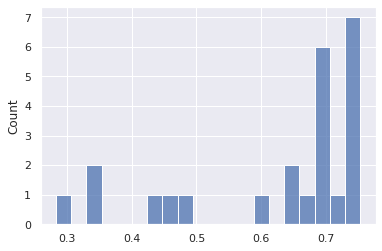

In [205]:
sns.histplot(results['pred'].values, bins=20)
plt.show()

ROC-AUC не изменился по сравнению с исходными ансамблями (значения ROC-AUC ансамблей равны между собой).

Точность - также без изменений.

Гистограмма, как и в предыдущем случае, состоит из двух половинок от двух соответствующих гистограмм исходных ансамблей.

In [206]:
np.min(np.abs(results['pred'].values - 0.5))

0.02101693921891573

## Вывод по обучению моделей

Обучено 6 различных моделей (ансамблей):
1. Базовая одиночная* модель, обученная на всех имеющихся признаках, гиперпараметры (далее - ГП) заданы произвольно.

Самая первая модель. Отправная точка для дальнейших идей и экспериментов. ROC-AUC = 0.97778; accuracy = 0.87500.

\* *под одиночной моделью здесь и далее понимается ансамбль из 45 моделей (5 folds * 3 repeats * 3 seeds), обученных в один проход.*

2. Базовая одиночная модель, обученная на части признаков, ГП - те же, что в п.1.

Отброшены малозначимые (по итогам обучения модели из п.1) признаки, а также признак caseType_1_frac (подробнее о нём - в разделе). Присутствие признака caseType_1_frac не является утечкой формально (целевой признак от него не зависит), но фактически приносит схожий эффект. Цель эксперимента - научить модель обходиться без признака caseType_1_frac. ROC-AUC = 0.97037; accuracy = 0.87500.

3. Ансамбль из 10 отобранных моделей, обученных на всех имеющихся признаках, диапазоны ГП заданы произвольно.

Сформирована сетка ГП, построено 200 моделей со случайно выбранными наборами ГП, отобраны 10 моделей с самым высоким средним ROC-AUC на валидации. Результат по ROC-AUC - ниже, чем у базовой модели (п.1), однако, есть основания полагать, что ансамбль будет работать стабильнее на новых данных. Желательно это проверить в дальнейшем. ROC-AUC = 0.94074; accuracy = 0.87500.

4. Ансамбль из 10 отобранных моделей, обученных на части признаков, диапазоны ГП - те же, что в п.3.

Отброшены малозначимые (по итогам обучения моделей из п.3) признаки, а также признак caseType_1_frac. Цель - создать ансамбль моделей, устойчивых к отсутствию признака caseType_1_frac. ROC-AUC = 0.94074; accuracy = 0.87500.

5. Является комбинацией п.п. 1 и 2.

Тестовая выборка разделена на две части: в первой части признак caseType_1_frac не равен нулю, во второй - равен. Модель из п.1 работает с первой частью выборки, модель из п.2 - со второй. Идея такова. Если есть данные о судах о банкротстве, то мы их используем. Если нет таких данных - в дело вступает модель, которой эти данные не нужны. ROC-AUC = 0.97778; accuracy = 0.87500.

6. Является комбинацией п.п. 3 и 4.

Идея аналогична п.5, только вместо базовых моделей используются ансамбли отобранных моделей. ROC-AUC = 0.94074; accuracy = 0.87500.

Точность любой из моделей - выше, чем точность константной модели (acc.const = 0.625), т.е. все модели являются адекватными. Ни одна из моделей не даёт ложноотрицательных ответов.

Лучший результат продемонстрировал ансамбль, описанный в п.5: совмещение базовых моделей, одна из которых обучена на полном наборе признаков, а другая - на сокращённом. Ещё раз покажем результат: ROC-AUC = 0.97778; accuracy = 0.87500.

# Общий вывод по работе

**Предобработка данных**

Данные собраны из разных источников и в исходном состоянии имеют разный вид: часть данных - в двух таблицах, другая часть - в отдельных файлах.

Заполнены пропуски, удалены дубликаты, выявлены и обработаны аномалии. Проверена полнота данных в разрезе компаний: удалены те компании, по которым часть данных отсутствовала.

Состояние исходных данных можно оценить как хорошее: на этапе предобработки удалено только 6,2% данных, а заполнение пропусков не привело к искажениям.

**Исследовательский анализ данных (EDA)**

Проанализированы факторы, влияющие на вероятность банкротства. Выявлены некоторые закономерности, подробно описанные в выводах внутри раздела. Обобщая, можно отметить, что в большинстве случаев банкротство не случается внезапно, и существует много признаков, указывающих на его скорое приближение. Некоторые признаки видны "невооружённым глазом", другие - выявляются моделью.

**Извлечение признаков**

Датасет построен относительно компаний (одна компания - одна строка).

Табличные данные рассмотрены как временные ряды, поскольку они содержат информацию по годам. Признаки сформированы на основе агрегированного представления ряда. Признаки в виде временных рядов (лаги, диффы и т.п.) не создавались, поскольку исходные временные ряды имеют разную длину и определены на разных отрезках временной оси. Некоторые признаки, а именно - булевы признаки, отражающие факт монотонности ряда, - оказались избыточными (не востребованы моделью).

Данные о судах, собранные из файлов, представлены тоже в агрегированном виде, поскольку количество судебных дел различается по компаниям. Категориальные переменные выражены через относительную частоту категорий, вещественные - через статистики.

Размер датасета: 154 строки; 55 столбцов.

**Построение моделей**

Выбранные метрики для оценки моделей: ROC-AUC, accuracy, confusion matrix. Эти метрики позволяют оценить точность модели, её стабильность, а также проанализировать характер ошибок. Ложноположительные ответы - это менее критичные ошибки, чем ответы ложноотрицательные. Поэтому важно понимать, какая именно ошибка повлияла на снижение точности (подробнее - в разделе).

Выделен целевой признак - факт банкротства.

Датасет разделён на обучающую и тестовую выборки в соотношении 0.85/0.15.

Обучение выполнено с применением 5-fold кросс-валидации, тремя вариантами разделения выборки на фолды (repeats), тремя вариантами инициализации модели перед обучением (lgbm seeds).

Обучено 6 различных моделей (ансамблей), подробно описанных в выводах по разделу. Лучший результат продемонстрировал ансамбль, где одна модель* обрабатывает строки, в которых есть информация о делах о банкротстве (признак caseType_1_frac не равен нулю), а другая модель - остальные строки. Результат: ROC-AUC = 0.97778; accuracy = 0.87500. Ложноотрицательных ответов нет, а по гистограмме видно, что модель в случае ошибки более склонна к ложноположительным ответам. Это - хорошо, так как ложноположительные ответы менее опасны (подробнее - в подразделе "Выбор метрик" в абзаце о Confusion matrix).

\* *под одиночной моделью здесь понимается ансамбль из 45 моделей (5 folds * 3 repeats * 3 seeds), обученных в один проход.*

**Заключение**

Исследование проводилось, главным образом, в разрезе компаний. Несмотря на весьма малый размер выборки (~150 компаний), удалось получить чёткие незашумлённые результаты исследования и сделать вполне определённые выводы. Также удалось построить модель (фактически - ансамбль из 90 моделей), которая предсказывает банкротство с высокой точностью. Ошибки модели - не фатальные: модель склонна "перестраховываться" и иногда предсказывает банкротство, когда его нет, но не наоборот.